In [1]:
import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt

In [2]:
# List of tickers for the 30 companies
# custom_tickers = [
#     "AMZN", "AXP", "AMGN", "AAPL", "BA",
#     "CAT", "CSCO", "CVX", "GS", "HD",
#     "HON", "IBM", "INTC", "JNJ", "KO",
#     "JPM", "MCD", "MMM", "MRK", "MSFT",
#     "NKE", "PG", "TRV", "UNH", "CRM",
#     "VZ", "V", "WMT", "DIS", "DJI"
# ]

#PAST DJIA
custom_tickers = [
    "PG", "JNJ", "XOM", "CVX", "MRK", "PFE", "MCD", "T",
    "VZ", "HPQ", "IBM", "MSFT", "INTC", "HD", "WMT", "TRV",
    "RTX", "BA", "AA", "DD", "CAT", "MMM", "DIS", "JPM", "AXP", "GE",
    "CCEP"
    #"CRJ", "H", "BOA","CCEP"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")

# Print the first few rows of the data for each ticker
for ticker in custom_tickers:
    if ticker in stock_data:
        print(f"Stock data for {ticker}:")
        print(stock_data[ticker].head())
        print("\n")

Stock data for PG:
                open      high       low     close  adjclose   volume ticker
1970-03-25  1.675781  1.761719  1.675781  1.703125  0.378553  1760000     PG
1970-03-26  1.703125  1.714844  1.695313  1.703125  0.378553   422400     PG
1970-03-30  1.687500  1.687500  1.660156  1.683594  0.374212   531200     PG
1970-03-31  1.683594  1.703125  1.681641  1.703125  0.378553   243200     PG
1970-04-01  1.718750  1.734375  1.718750  1.726563  0.383763   806400     PG


Stock data for JNJ:
                open      high       low     close  adjclose   volume ticker
1970-03-25  1.062500  1.100694  1.062500  1.086806  0.337554  2275200    JNJ
1970-03-26  1.086806  1.093750  1.083333  1.086806  0.337554   936000    JNJ
1970-03-30  1.086806  1.092014  1.079861  1.081597  0.335936  1368000    JNJ
1970-03-31  1.076389  1.076389  1.065972  1.072917  0.333240   676800    JNJ
1970-04-01  1.069444  1.069444  1.062500  1.065104  0.330814   820800    JNJ


Stock data for XOM:
             

PG


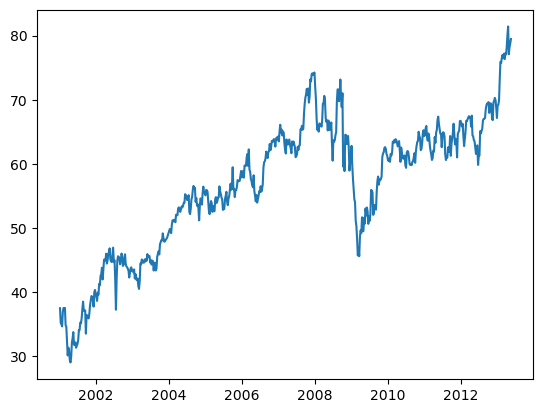

JNJ


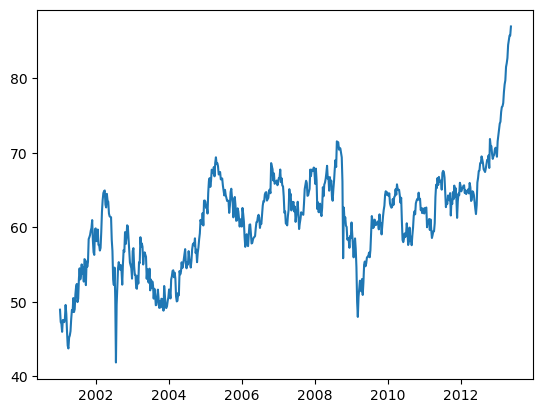

XOM


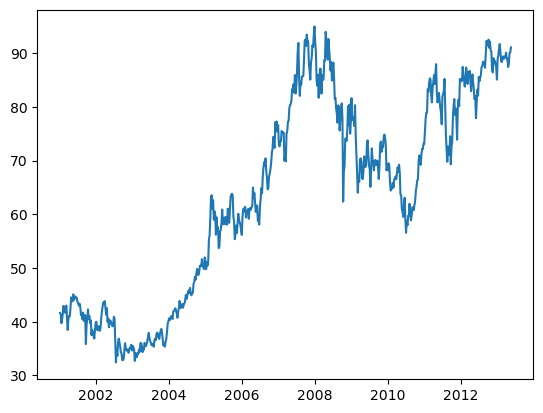

CVX


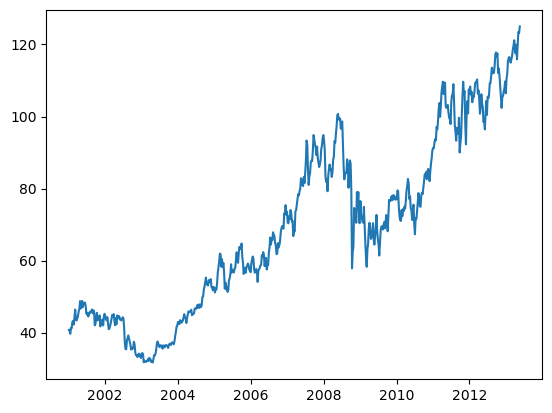

MRK


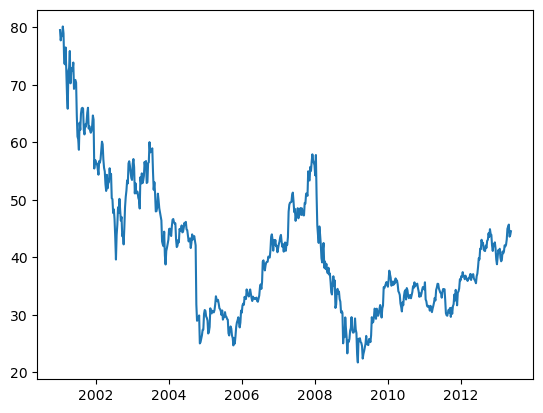

PFE


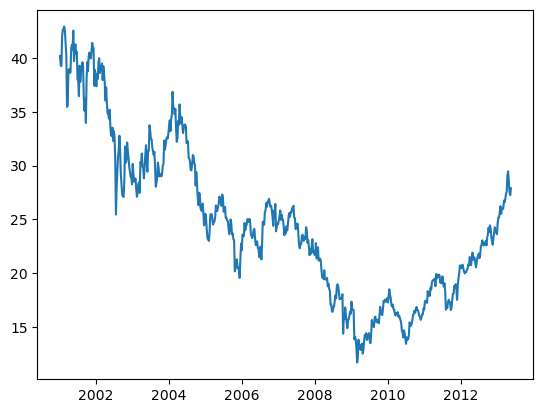

MCD


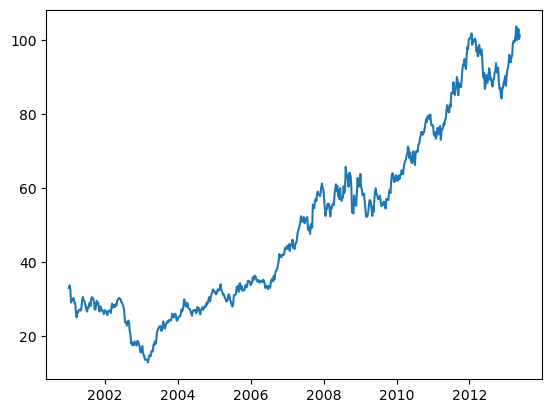

T


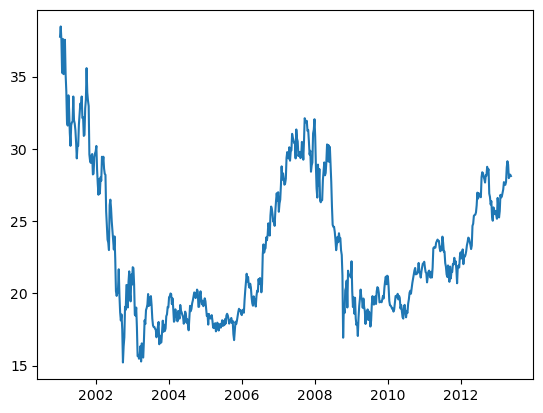

VZ


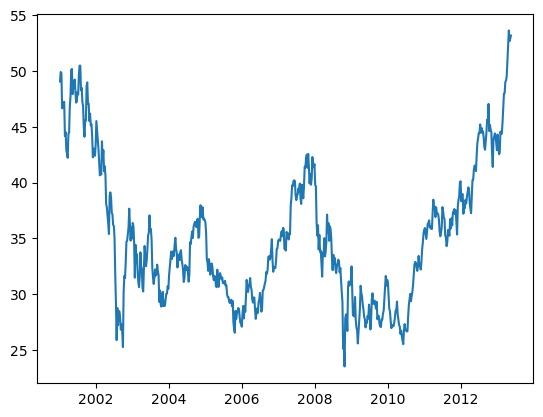

HPQ


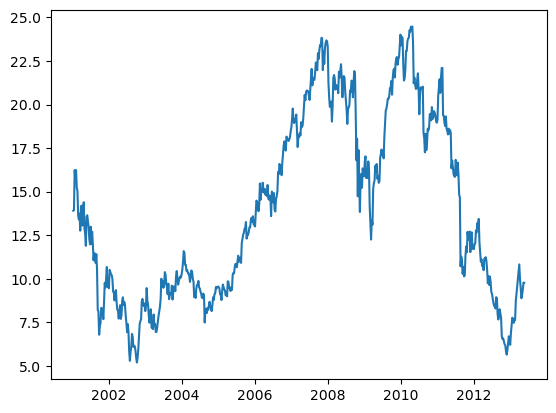

IBM


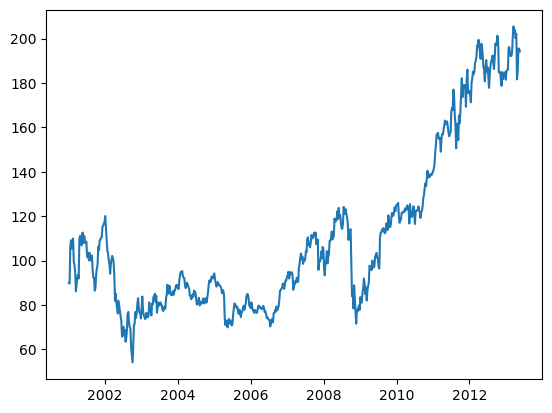

MSFT


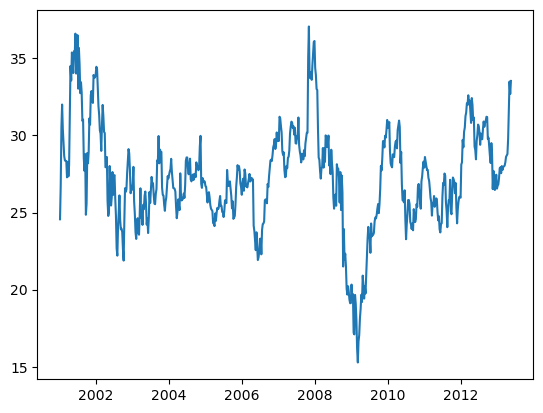

INTC


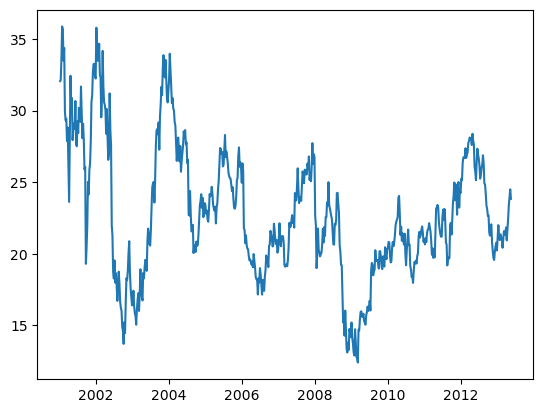

HD


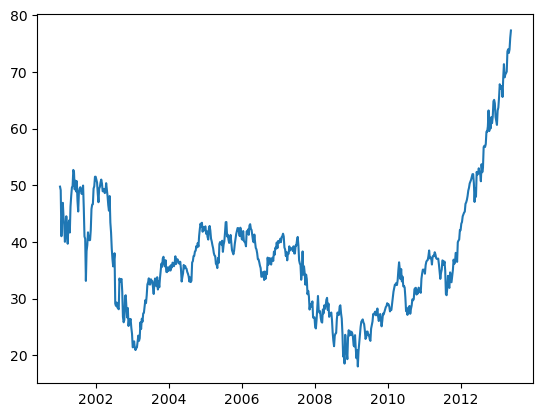

WMT


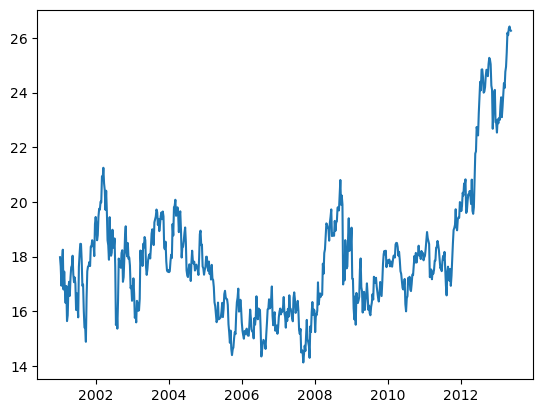

TRV


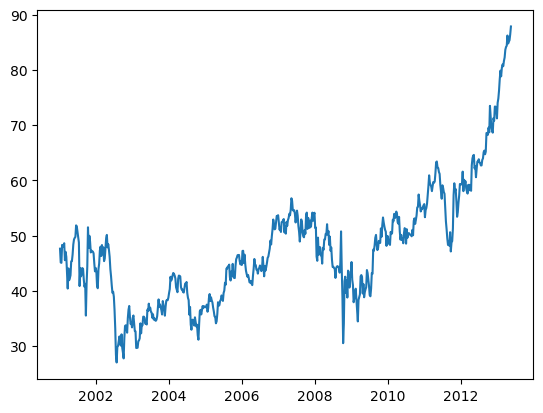

RTX


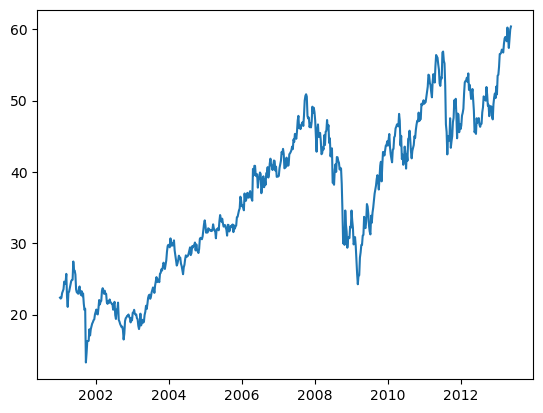

BA


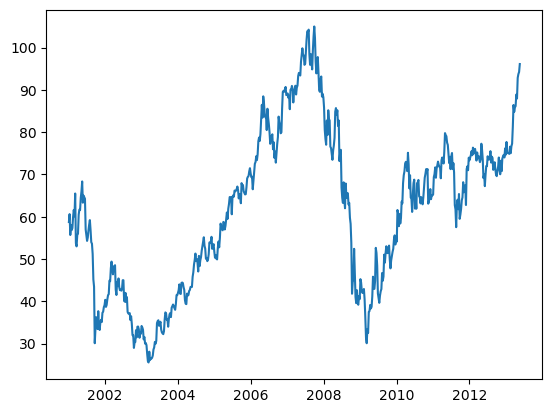

AA


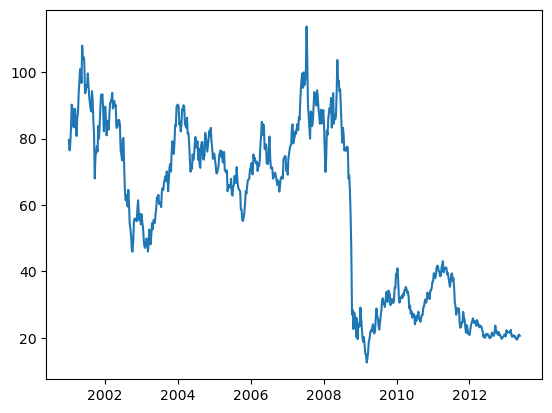

DD


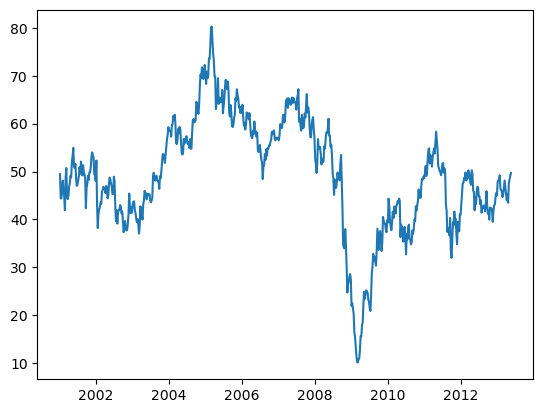

CAT


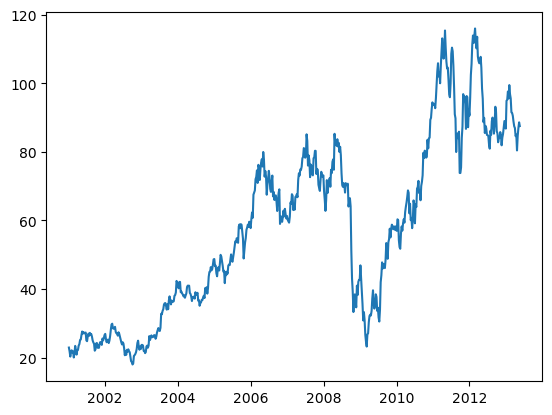

MMM


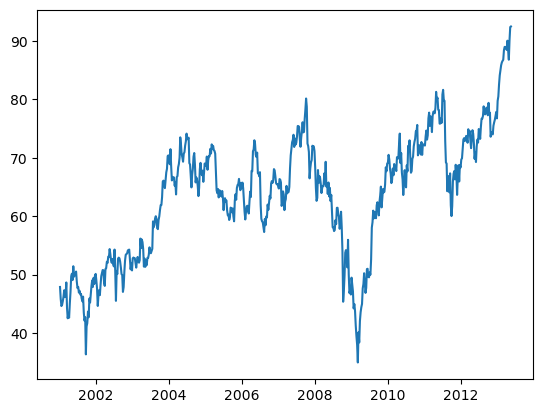

DIS


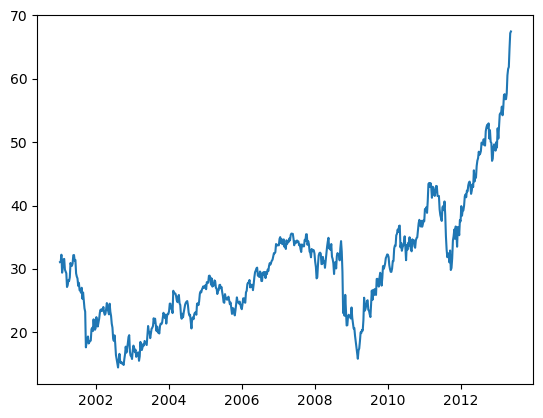

JPM


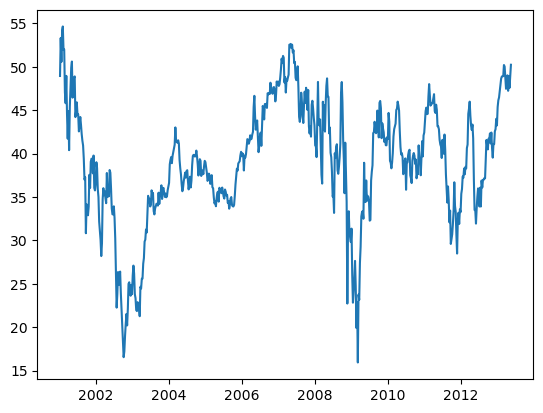

AXP


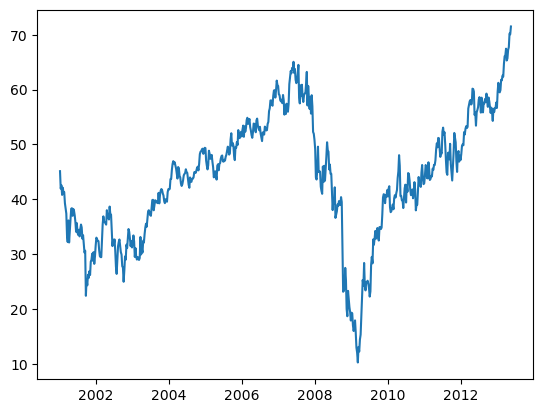

GE


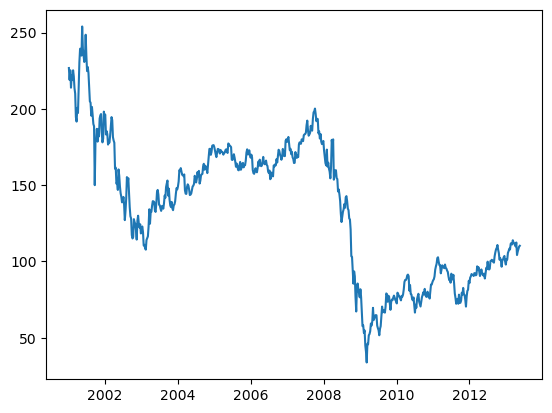

CCEP


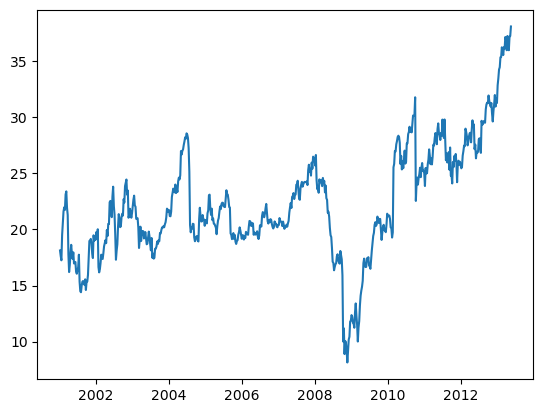

In [3]:
def calculate_weekly_returns(df):
    weekly_df = df.resample('W').last()
    weekly_df['close'].fillna(method='ffill', inplace=True)
    weekly_df['returns'] = weekly_df['close'].pct_change().fillna(0)
    return weekly_df

weekly_returns_dict = {}

for ticker, data in stock_data.items():
    data = data.loc['2001-01-02':'2013-05-14']
    data.index = pd.to_datetime(data.index)
    weekly_returns = calculate_weekly_returns(data)
    weekly_returns_dict[ticker] = weekly_returns

for i in custom_tickers:
    print(i)
    plt.plot(weekly_returns_dict[i].index,weekly_returns_dict[i]["close"])
    plt.show()

In [4]:
study_periods = [
    ('2001-01-02', '2004-01-06'),
    ('2004-01-06', '2007-01-02'),
    ('2007-01-02', '2010-01-05'),
    ('2010-01-05', '2013-05-14')
]

weekly_returns_dict = {}

for ticker, data in stock_data.items():
    data.index = pd.to_datetime(data.index)
    
    for period_num, (start_date, end_date) in enumerate(study_periods, start=1):
        period_data = data.loc[start_date:end_date]
        period_returns = calculate_weekly_returns(period_data)
        weekly_returns_dict.setdefault(ticker, {})[f'period_{period_num}'] = period_returns

In [5]:
period_dfs = {}

# Iterate over the periods
for period in ['period_1', 'period_2', 'period_3', 'period_4']:
    # Initialize an empty dictionary to store data for the current period
    period_data = {}
    
    # Iterate over each ticker's data
    for ticker, data in weekly_returns_dict.items():
        # Drop NaN values from the 'close' column for the current period
        close_prices = data[period][['returns']].dropna()
        period_data[ticker] = close_prices
    
    # Concatenate the data for all tickers into a single DataFrame for the current period
    period_df = pd.concat(period_data, axis=1)
    period_dfs[period] = period_df.dropna(axis=1)

correlation_matrices = {}

# Iterate over the periods
for period, period_df in period_dfs.items():
    # Calculate correlation matrix for the current period and store it in the dictionary
    correlation_matrices[period] = period_df.corr()


/var/folders/m7/j4dcn39d2w53ww84yjmrzn2r0000gn/T/ipykernel_88937/880257797.py:25: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward') #'ward'
/Users/kellymi/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:446: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='average', metric='euclidean')


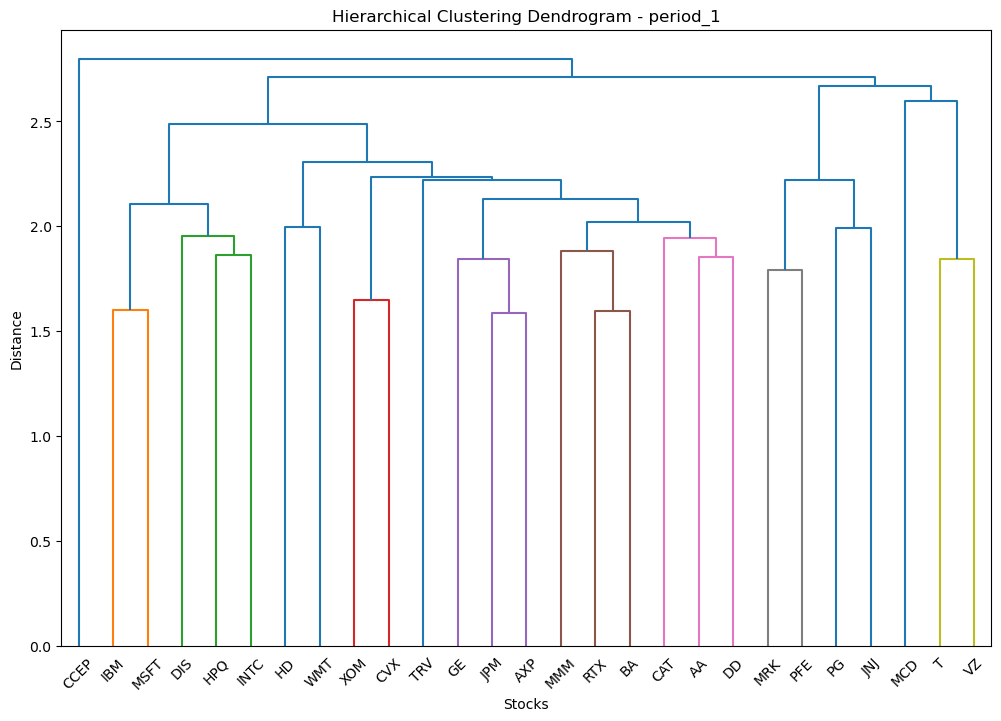

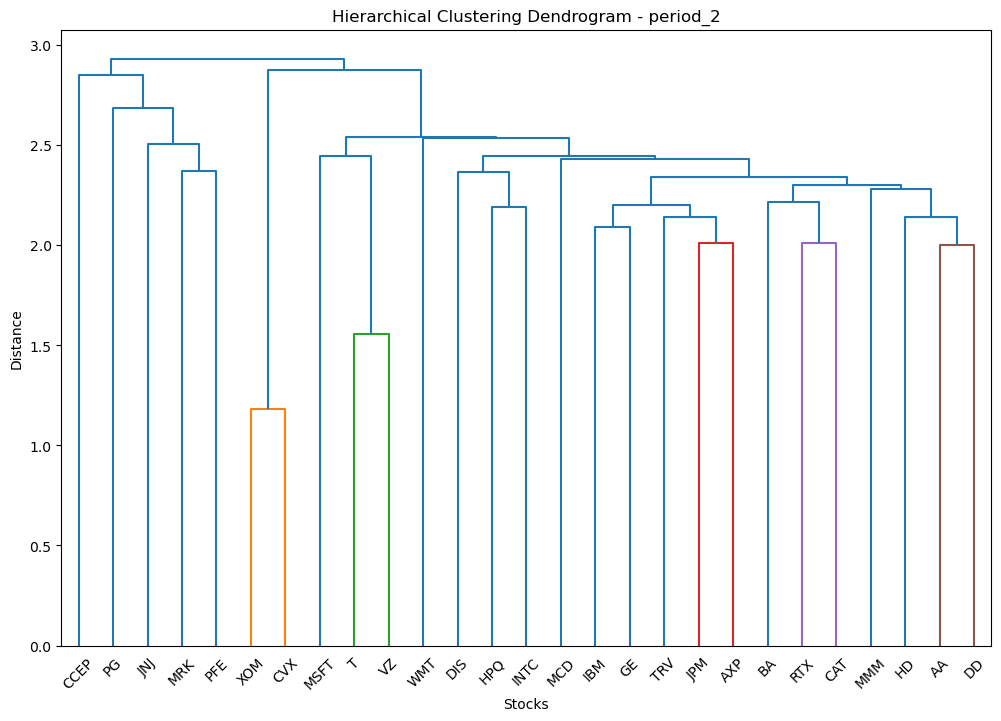

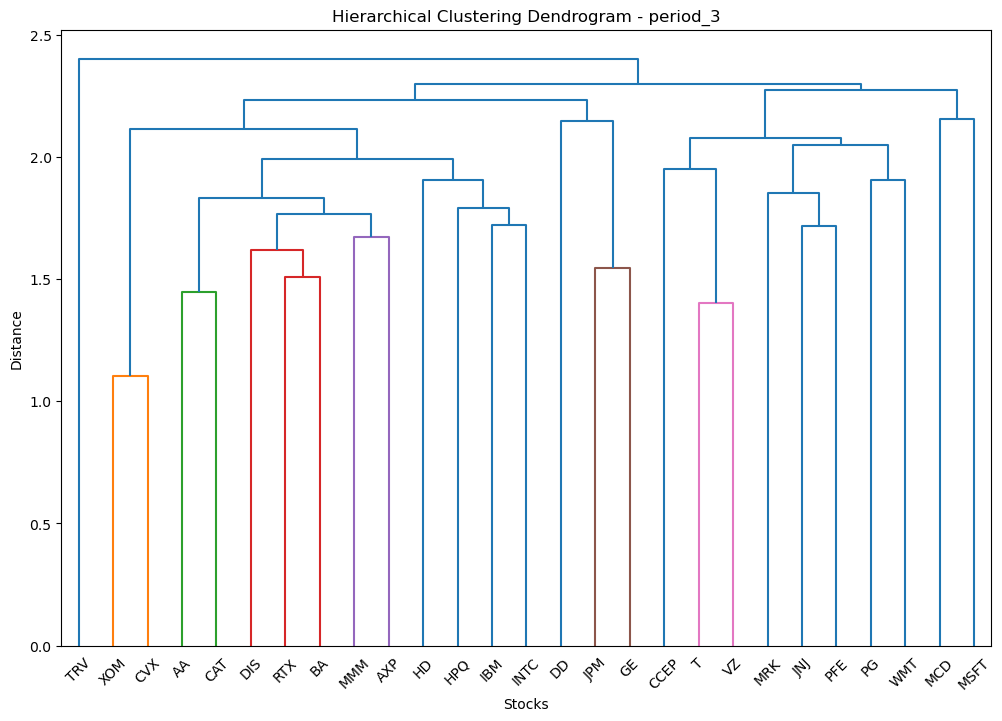

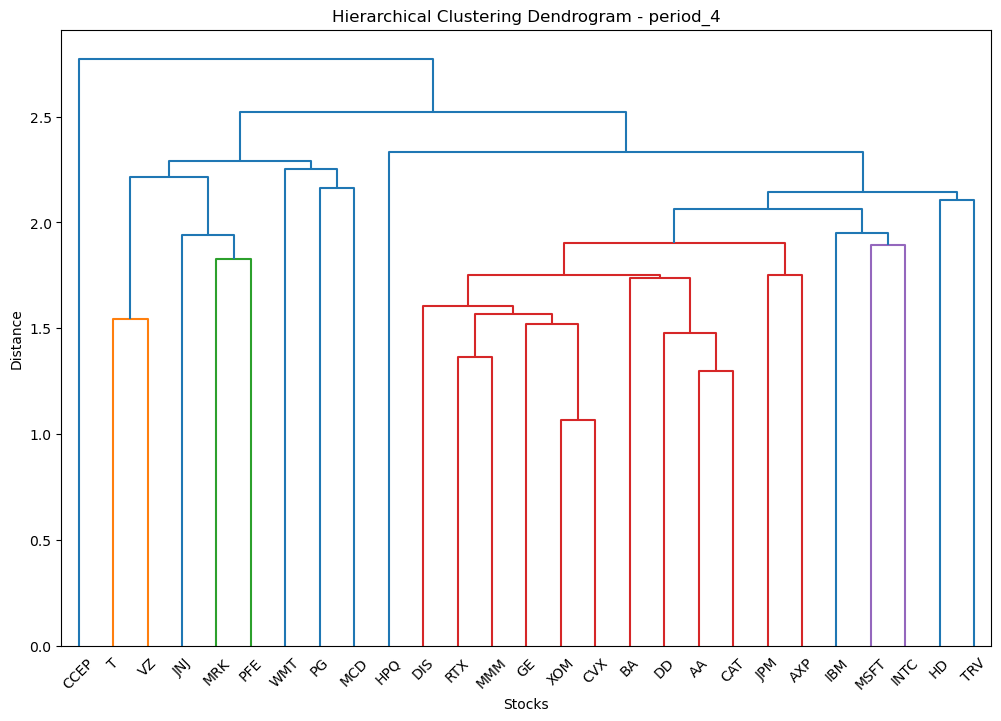

In [6]:
import numpy as np
from scipy.cluster.hierarchy import average, fcluster, linkage
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def ultrametric(correlation_matrix, q=2):
    """
    Convert a correlation matrix to an ultrametric distance matrix.

    Parameters:
        correlation_matrix (pd.DataFrame): Correlation matrix of stocks.
        q (float): Exponent parameter (default is 2).

    Returns:
        pd.DataFrame: Ultrametric distance matrix.
    """
    # Calculate the ultrametric distance matrix
    ultrametric_distances = q * (1 - correlation_matrix) ** (1/q)
    
    return ultrametric_distances

# Function to perform hierarchical clustering and print stocks in each cluster
def hierarchical_clustering(distance_matrix, labels, period):
#    linkage_matrix = average(distance_matrix)
    linkage_matrix = linkage(distance_matrix, method='ward') #'ward'
    labels = [label[0] for label in labels]

    # Set the figure size to be larger
    plt.figure(figsize=(12, 8))  # Adjust the size as needed

    # Plot the dendrogram
    dendrogram(average(distance_matrix), labels=labels, orientation='top')

    # Customize plot title and axis labels
    plt.title(f'Hierarchical Clustering Dendrogram - {period}')
    plt.xlabel('Stocks')
    plt.ylabel('Distance')

    # Create dictionary to store stocks in each cluster for 2, 4, and 8 clusters
    cluster_stocks = {num_clusters: {} for num_clusters in [2, 4, 8]}
    
    # Perform clustering to get cluster labels for 2, 4, and 8 clusters
    for num_clusters in [2, 4, 8]:
        cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
        
        # Assign stocks to clusters
        for stock, cluster_label in zip(labels, cluster_labels):
            if cluster_label not in cluster_stocks[num_clusters]:
                cluster_stocks[num_clusters][cluster_label] = [stock]
            else:
                cluster_stocks[num_clusters][cluster_label].append(stock)

    # Show the plot
    plt.show()
    
    return cluster_stocks

# Convert new correlation matrices to distance matrices using ultrametric function
distance_matrices = {}
for period, correlation_matrix in correlation_matrices.items():
    distance_matrices[period] = ultrametric(correlation_matrix)

# Create a dictionary to store cluster stocks for each period
all_cluster_stocks = {}

# Perform hierarchical clustering and plot dendrogram for each study period
for period, distance_matrix in distance_matrices.items():
    all_cluster_stocks[period] = hierarchical_clustering(distance_matrix.values, distance_matrix.index, period)


In [7]:
def calculate_metrics_for_random_selection(period_dfs, num_stocks_list):
    results_by_period = {}
    num_portfolios = 100
 
    for period, returns_data in period_dfs.items():
        returns_data = returns_data.droplevel(1, axis=1)
        #print(returns_data)
        results_by_stocks = {}
        stocks_length_list = {}
        #print(returns_data)
        
        for num_stocks in num_stocks_list:
            std_returns = []
            portfolio_returns = []
            correlation = []
            selected_stocks_list = {}
            
            for _ in range(num_portfolios):
                selected_stocks = np.random.choice(returns_data.columns, size=num_stocks, replace=False)
                
                try:
                    selected_stocks_list[num_stocks] = np.concatenate([selected_stocks_list[num_stocks], selected_stocks])
                except KeyError:
                    selected_stocks_list[num_stocks] = selected_stocks
               
                
                portfolio_return_stocks = returns_data[selected_stocks].mean(axis=1)
                mean_portfolio_return = np.prod(1+portfolio_return_stocks)-1
                portfolio_returns.append(mean_portfolio_return)
                
                
                mean_std = (portfolio_return_stocks).std()
                std_returns.append(mean_std)
                
                correlation_matrix = returns_data[selected_stocks].corr()
                upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                upper_triangle_flat = upper_triangle.stack().dropna().tolist()
                mean_correlation = np.mean(upper_triangle_flat)
                correlation = mean_correlation
            
            #stocks_length_list[period] = selected_stocks_list
            
            sharpe_ratio = np.mean((np.array(portfolio_returns)/10) / np.array(std_returns))
            mean_return = np.mean(portfolio_returns)
            mean_std = np.mean(std_returns)
            final_stocks_list = [list(i) for i in selected_stocks_list.values()]
            
            results_by_stocks[num_stocks] = {'Mean': mean_return, 'SD': mean_std, 'Sharpe': sharpe_ratio, 'Correlation': mean_correlation, "Stocks" : final_stocks_list}

        results_by_period[period] = results_by_stocks
    
    return results_by_period

num_stocks_list = [2, 4, 8]

results_by_period = calculate_metrics_for_random_selection(period_dfs, num_stocks_list)

dfs = []
for period, results_by_stocks in results_by_period.items():
    for num_stocks, metrics in results_by_stocks.items():
        df = pd.DataFrame(metrics, index=[f"{period} ({num_stocks} stocks)"])
        dfs.append(df)

result_df_random = pd.concat(dfs)
result_df_random

Mean        SD    Sharpe  Correlation  \
period_1 (2 stocks)  0.032832  0.036819  0.106266     0.290960   
period_1 (4 stocks)  0.013559  0.032681  0.044636     0.345051   
period_1 (8 stocks)  0.027156  0.030573  0.089394     0.304053   
period_2 (2 stocks)  0.284934  0.021759  1.371216     0.118892   
period_2 (4 stocks)  0.250866  0.018364  1.389442     0.281626   
period_2 (8 stocks)  0.254824  0.016167  1.589540     0.219969   
period_3 (2 stocks) -0.023456  0.044953 -0.021285     0.503355   
period_3 (4 stocks) -0.008881  0.040129 -0.005337     0.605161   
period_3 (8 stocks)  0.003025  0.038511  0.016009     0.497064   
period_4 (2 stocks)  0.497705  0.026836  1.973020     0.629944   
period_4 (4 stocks)  0.476010  0.024254  2.075423     0.456668   
period_4 (8 stocks)  0.421384  0.023840  1.792871     0.473768   

                                                                Stocks  
period_1 (2 stocks)  [MMM, MSFT, HD, BA, JPM, CCEP, GE, TRV, MRK, C...  
period_1 (4 stocks)  [AXP, MSFT, INTC, MCD, XOM, IBM, HD, BA, HD, C...  
period_1 (8 stocks)  [TRV, HPQ, CCEP, AA, AXP, JPM, T, MSFT, INTC, ...  
period_2 (2 stocks)  [HPQ, AXP, GE, CVX, TRV, MMM, WMT, PG, JPM, VZ...  
period_2 (4 stocks)  [DIS, AA, CCEP, GE, BA, AXP, CVX, HD, MCD, INT...  
period_2 (8 stocks)  [RTX, MMM, HD, DD, BA, VZ, IBM, MSFT, MMM, AXP...  
period_3 (2 stocks)  [PFE, AXP, DD, JNJ, DIS, JNJ, MMM, T, MRK, MSF...  
period_3 (4 stocks)  [CVX, RTX, PFE, VZ, VZ, JPM, INTC, WMT, IBM, M...  
period_3 (8 stocks)  [T, AXP, MCD, PFE, MRK, MMM, CCEP, RTX, MSFT, ...  
period_4 (2 stocks)  [DD, T, AXP, IBM, WMT, DIS, RTX, CVX, MRK, AA,...  
period_4 (4 stocks)  [MMM, WMT, CVX, AXP, IBM, HD, AA, T, BA, HD, T...  
period_4 (8 stocks)  [CAT, GE, WMT, CVX, IBM, AXP, JPM, PFE, TRV, D...

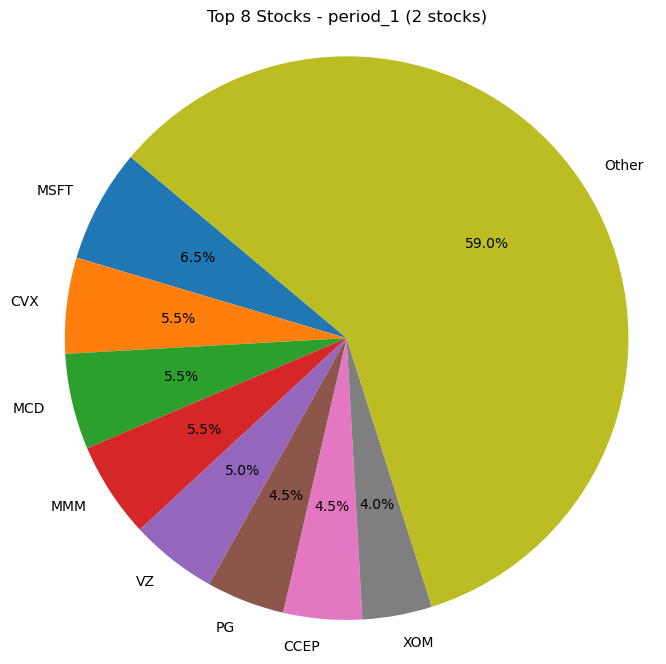

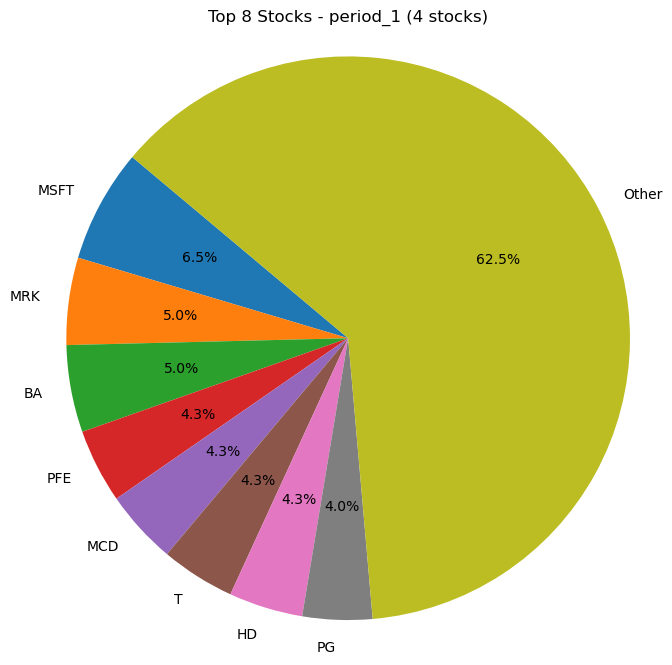

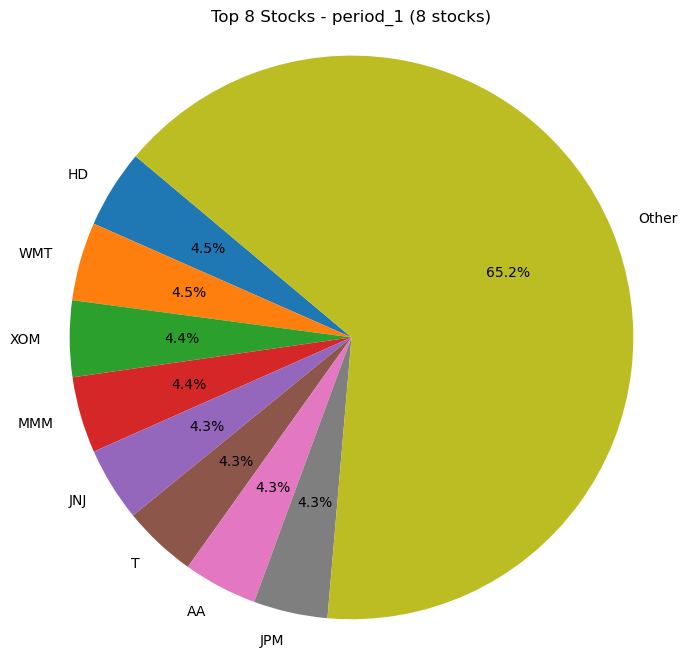

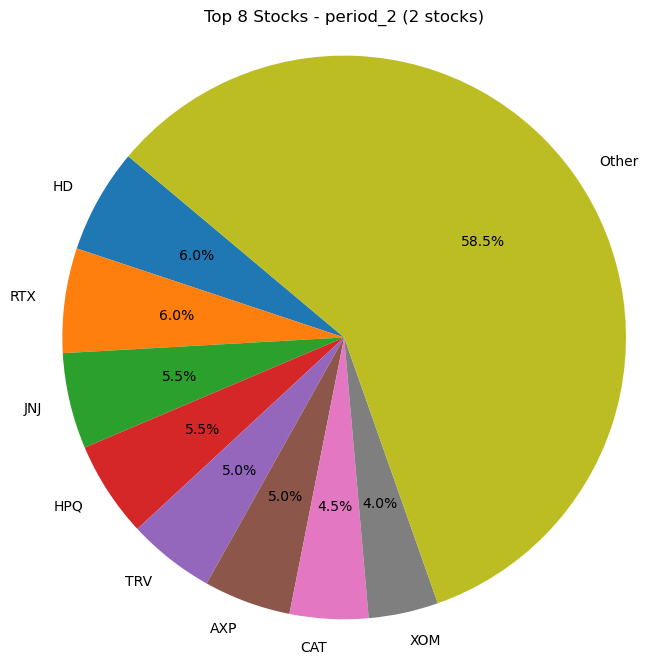

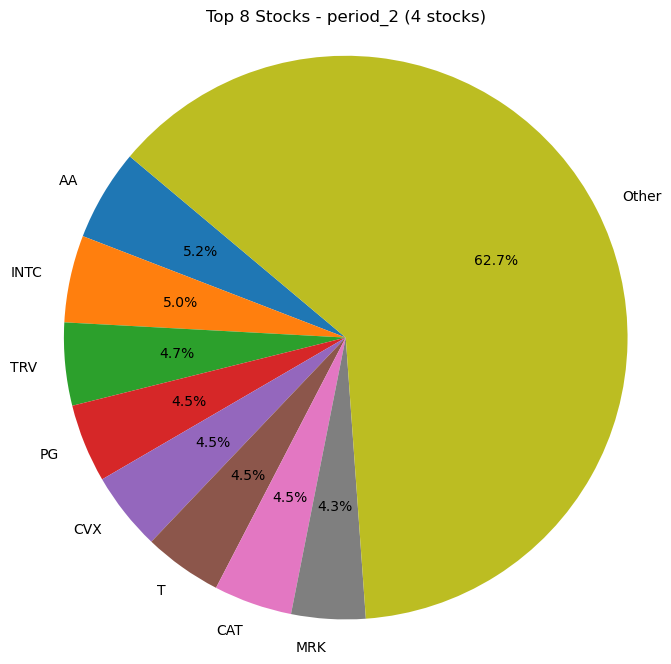

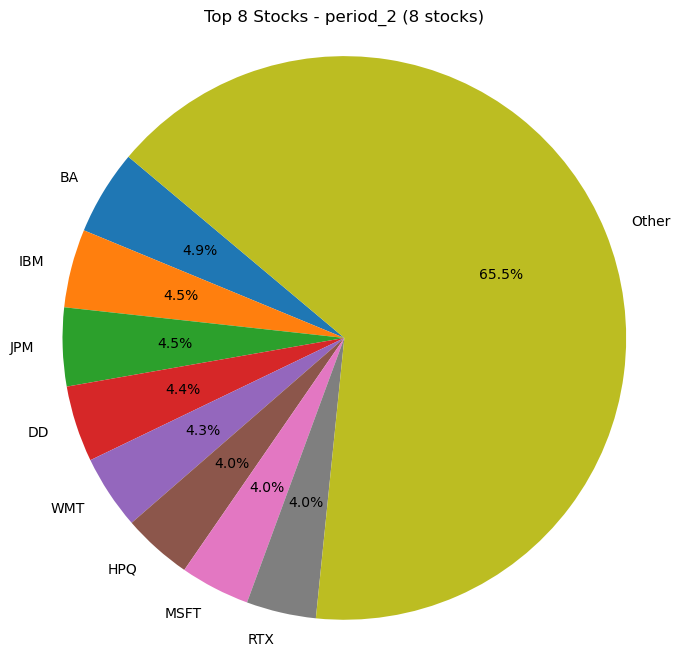

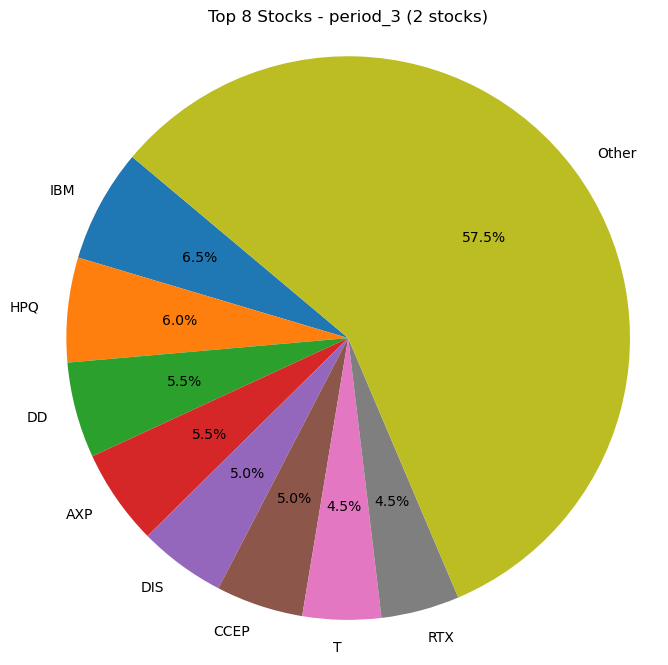

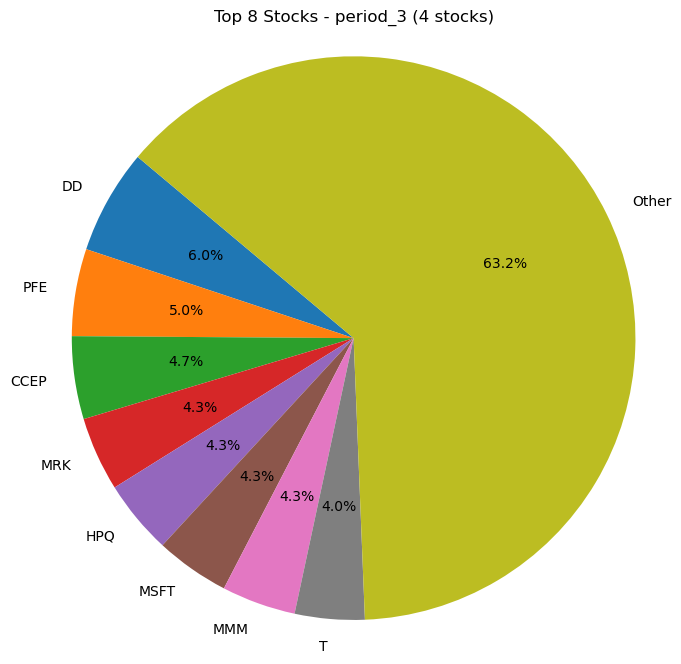

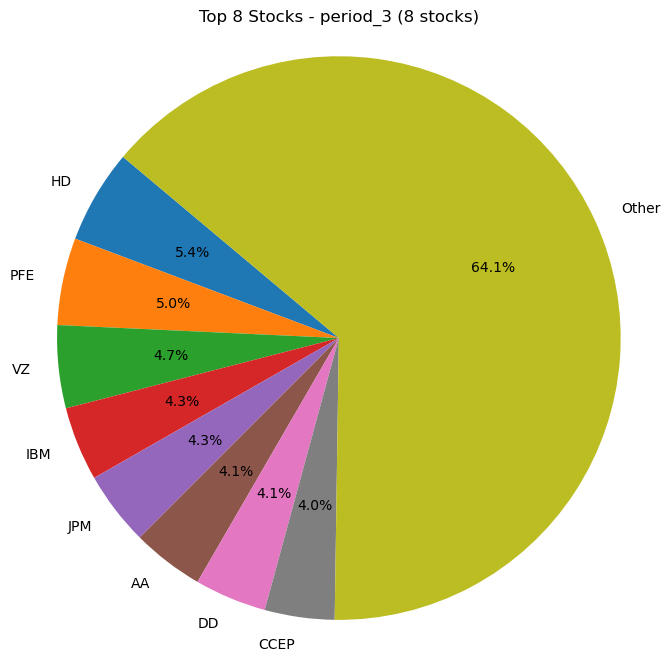

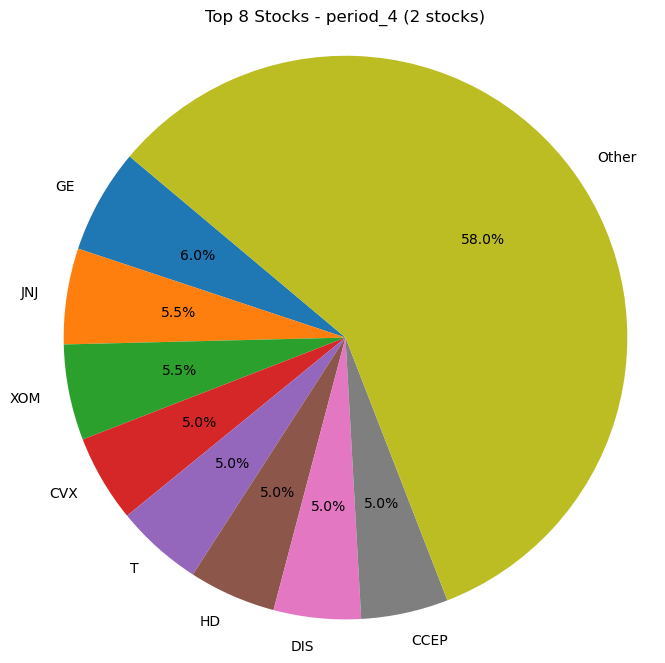

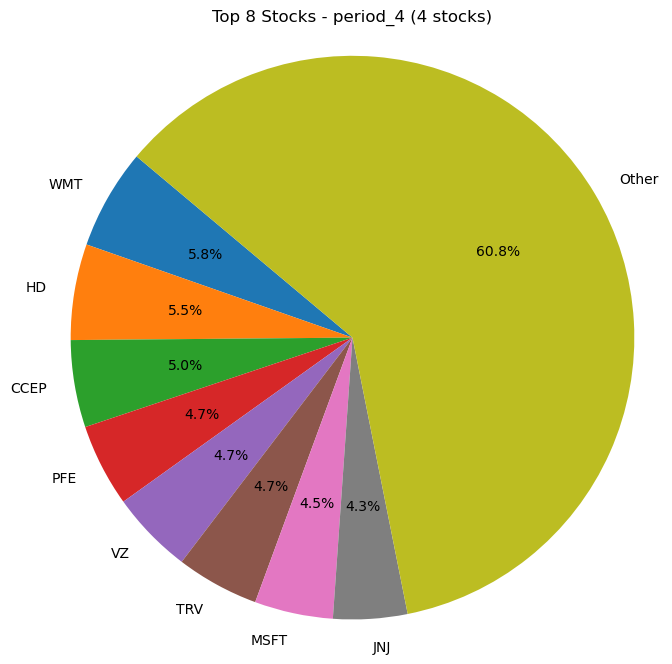

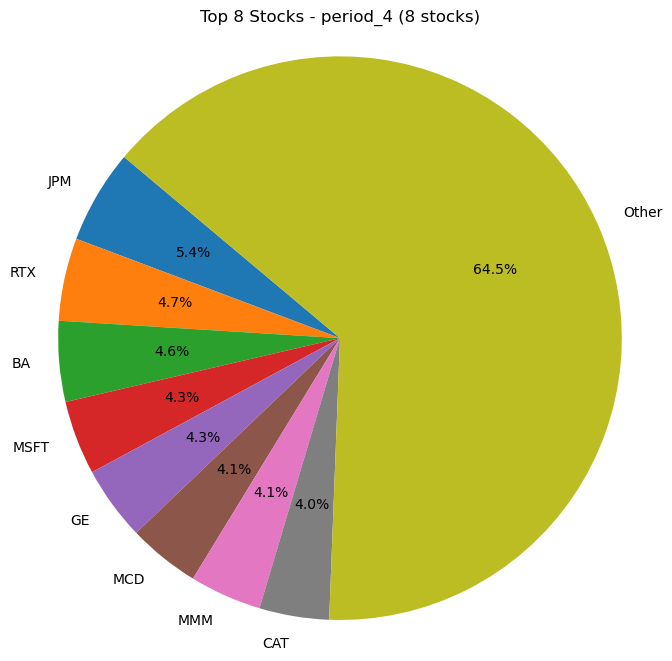

In [8]:
for period, group in result_df_random.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers, columns=[period])

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers
    total_counts = counts_df.sum(axis=1)

    # Get the top 8 stocks and group the rest into "Other"
    top_8 = total_counts.nlargest(8)
    other = pd.Series(total_counts.sum() - top_8.sum(), index=["Other"])

    # Concatenate the top 8 and "Other"
    final_counts = pd.concat([top_8, other])

    # Plot the pie chart for the current period
    plt.figure(figsize=(8, 8))
    plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Top 8 Stocks - {period}')
    plt.show()

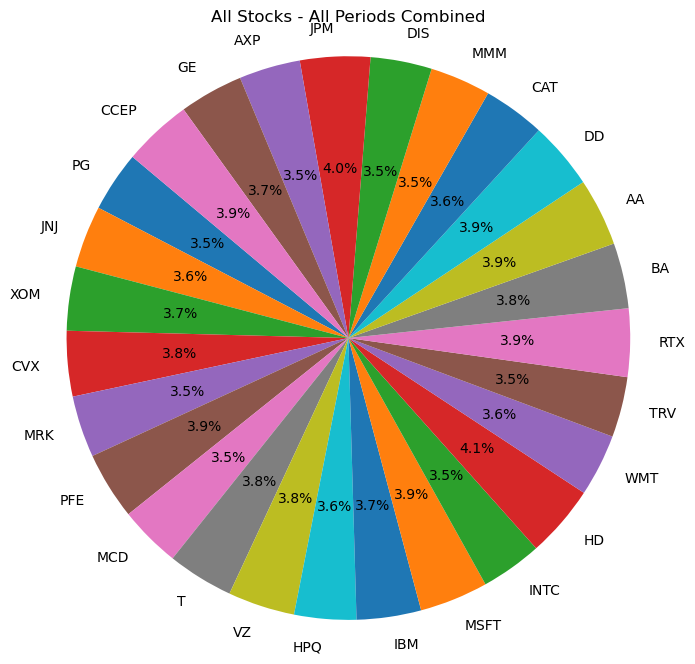

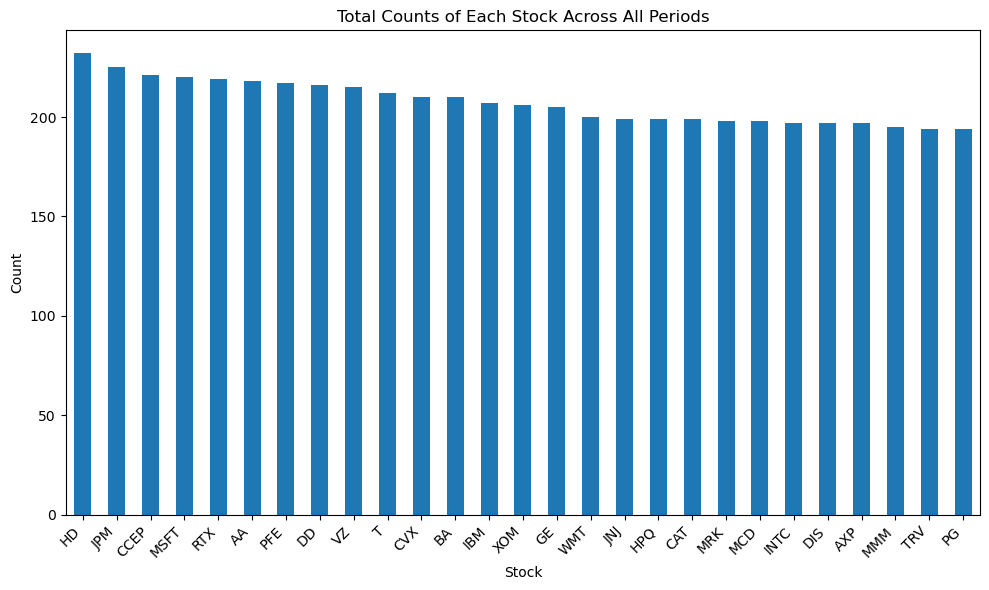

In [9]:
total_counts_df = pd.DataFrame(index=custom_tickers)

# Iterate over each period
for period, group in result_df_random.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers)

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers for the current period
    total_counts_df[period] = counts_df.sum(axis=1)

# Sum the counts across all periods
total_counts = total_counts_df.sum(axis=1)

# Plot the pie chart for all periods combined
plt.figure(figsize=(8, 8))
plt.pie(total_counts, labels=total_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('All Stocks - All Periods Combined')
plt.show()

total_counts_df = pd.DataFrame(index=custom_tickers)

# Iterate over each period
for period, group in result_df_random.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers)

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers for the current period
    total_counts_df[period] = counts_df.sum(axis=1)

# Sum the counts across all periods
total_counts = total_counts_df.sum(axis=1)

# Sort the total counts in descending order
total_counts_sorted = total_counts.sort_values(ascending=False)

# Plot the bar chart for all periods combined
plt.figure(figsize=(10, 6))
total_counts_sorted.plot(kind='bar')
plt.xlabel('Stock')
plt.ylabel('Count')
plt.title('Total Counts of Each Stock Across All Periods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
#CLUSTERS

import pandas as pd
import numpy as np

def calculate_metrics_for_all_clusters(all_cluster_stocks, period_dfs):
    results_by_period = {}
    num_portfolios = 100
    
    for period, cluster_stocks in all_cluster_stocks.items():
        returns_data = period_dfs[period].droplevel(1, axis=1)
        results_by_cluster = {}
        selected_stocks_list = {}
        #print(returns_data)
        
        for num_clusters, clusters in cluster_stocks.items():
            cluster_lists = list(clusters.values())
            std_returns = []
            portfolio_returns = []
            #print(cluster_lists)
            correlation = 0
            
            for _ in range(num_portfolios):
                # First, choose stocks from each cluster
                selected_stocks = [np.random.choice(cluster_list, size=1)[0] for cluster_list in cluster_lists]
                
                try:
                    selected_stocks_list[num_stocks] = np.concatenate([selected_stocks_list[num_stocks], selected_stocks])
                except KeyError:
                    selected_stocks_list[num_stocks] = selected_stocks
                
                portfolio_return_stocks = returns_data[selected_stocks].mean(axis=1)
                
                
                mean_portfolio_return = np.prod(1+portfolio_return_stocks)-1
                portfolio_returns.append(mean_portfolio_return)
                
                #print(returns_data[selected_stocks].std())
                mean_std = (portfolio_return_stocks+1).std()
                std_returns.append(mean_std)
                
                correlation_matrix = returns_data[selected_stocks].corr()
                upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                upper_triangle_flat = upper_triangle.stack().dropna().tolist()
                mean_correlation = np.mean(upper_triangle_flat)
                correlation = mean_correlation
            plt.show()
            
            sharpe_ratio = np.mean((np.array(portfolio_returns)/10) / np.array(std_returns))
            mean_return = np.mean(portfolio_returns)
            mean_std = np.mean(std_returns)
            
            final_stocks_list = [list(i) for i in selected_stocks_list.values()]
            
            results_by_cluster[num_clusters] = {'Mean': mean_return, 'SD': mean_std, 'Sharpe': sharpe_ratio, 'Correlation': mean_correlation, "Stocks" : final_stocks_list}
            #print()
        results_by_period[period] = results_by_cluster
    
    return results_by_period

#results_by_period = calculate_metrics_for_all_clusters(all_cluster_stocks, period_dfs)
#results_by_period


results_by_period = calculate_metrics_for_all_clusters(all_cluster_stocks, period_dfs)

dfs = []
for period, results_by_cluster in results_by_period.items():
    for num_clusters, metrics in results_by_cluster.items():
        df = pd.DataFrame(metrics, index=[f"{period} ({num_clusters} stocks)"])
        dfs.append(df)

result_df_clusters = pd.concat(dfs)
result_df_clusters

Mean        SD    Sharpe  Correlation  \
period_1 (2 stocks) -0.043514  0.035350 -0.093538     0.413708   
period_1 (4 stocks) -0.015203  0.030969 -0.041446     0.304134   
period_1 (8 stocks) -0.007176  0.028062 -0.022446     0.285577   
period_2 (2 stocks)  0.272391  0.020930  1.395657     0.369057   
period_2 (4 stocks)  0.340532  0.016610  2.096146     0.232062   
period_2 (8 stocks)  0.232804  0.013829  1.710195     0.194128   
period_3 (2 stocks) -0.005788  0.040173  0.012488     0.513917   
period_3 (4 stocks) -0.010786  0.042699 -0.024797     0.538272   
period_3 (8 stocks) -0.003285  0.034601 -0.009045     0.473445   
period_4 (2 stocks)  0.475097  0.026053  1.913479     0.584977   
period_4 (4 stocks)  0.549306  0.025476  2.207991     0.461944   
period_4 (8 stocks)  0.476970  0.022972  2.095122     0.449159   

                                                                Stocks  
period_1 (2 stocks)  [VZ, AXP, PG, DIS, JNJ, IBM, T, WMT, MCD, TRV,...  
period_1 (4 stocks)  [VZ, AXP, PG, DIS, JNJ, IBM, T, WMT, MCD, TRV,...  
period_1 (8 stocks)  [VZ, AXP, PG, DIS, JNJ, IBM, T, WMT, MCD, TRV,...  
period_2 (2 stocks)  [CCEP, CAT, CVX, TRV, PG, VZ, CVX, VZ, MRK, BA...  
period_2 (4 stocks)  [CCEP, CAT, CVX, TRV, PG, VZ, CVX, VZ, MRK, BA...  
period_2 (8 stocks)  [CCEP, CAT, CVX, TRV, PG, VZ, CVX, VZ, MRK, BA...  
period_3 (2 stocks)  [T, HD, PG, HPQ, VZ, DIS, MCD, JPM, TRV, IBM, ...  
period_3 (4 stocks)  [T, HD, PG, HPQ, VZ, DIS, MCD, JPM, TRV, IBM, ...  
period_3 (8 stocks)  [T, HD, PG, HPQ, VZ, DIS, MCD, JPM, TRV, IBM, ...  
period_4 (2 stocks)  [CCEP, MMM, TRV, HD, TRV, CVX, PFE, DIS, PG, G...  
period_4 (4 stocks)  [CCEP, MMM, TRV, HD, TRV, CVX, PFE, DIS, PG, G...  
period_4 (8 stocks)  [CCEP, MMM, TRV, HD, TRV, CVX, PFE, DIS, PG, G...

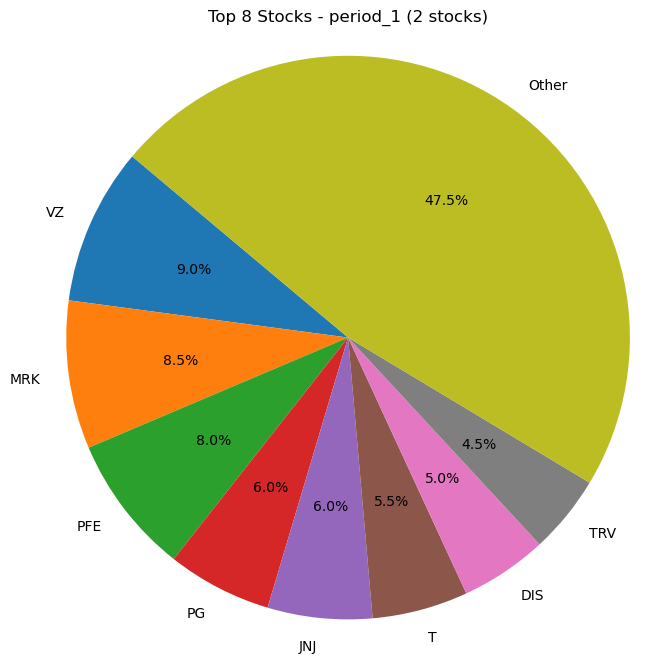

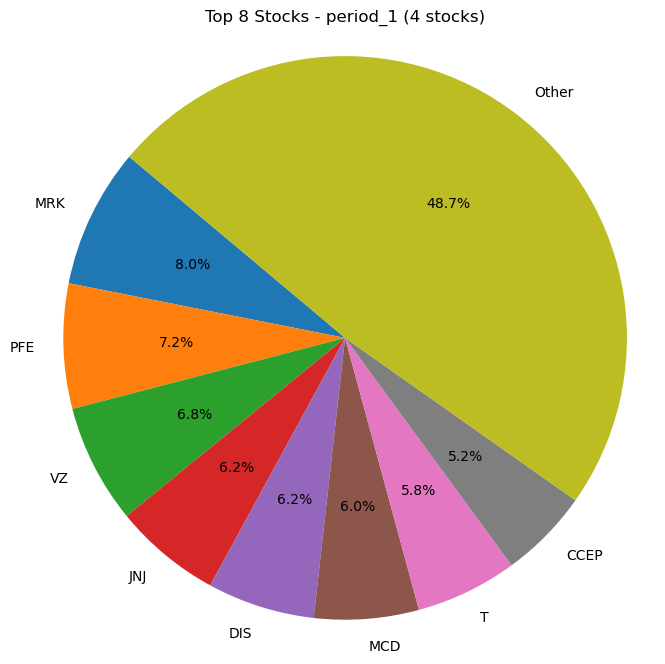

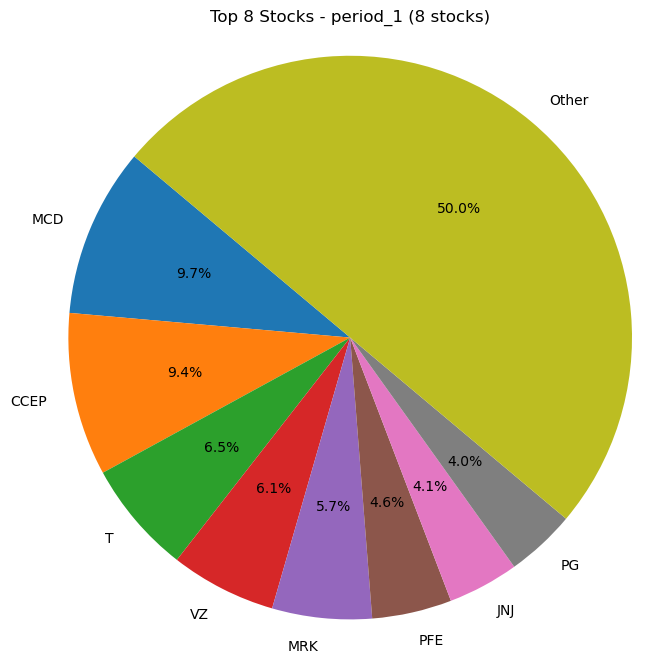

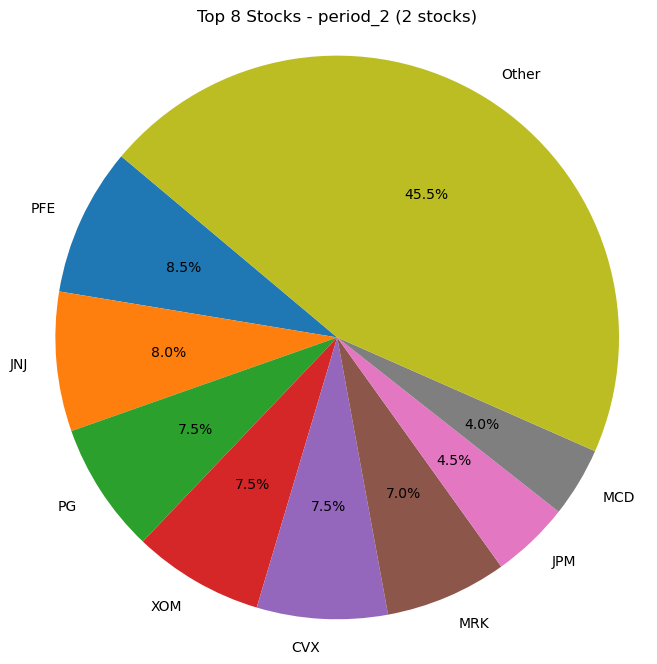

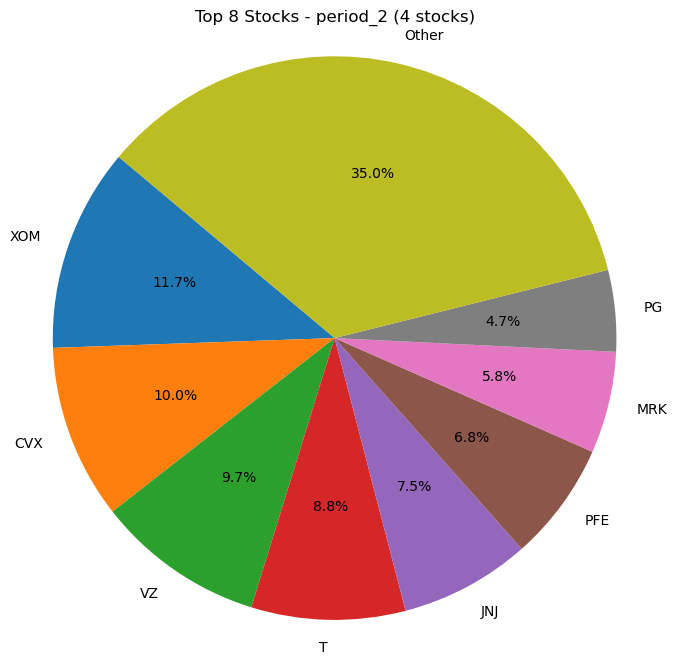

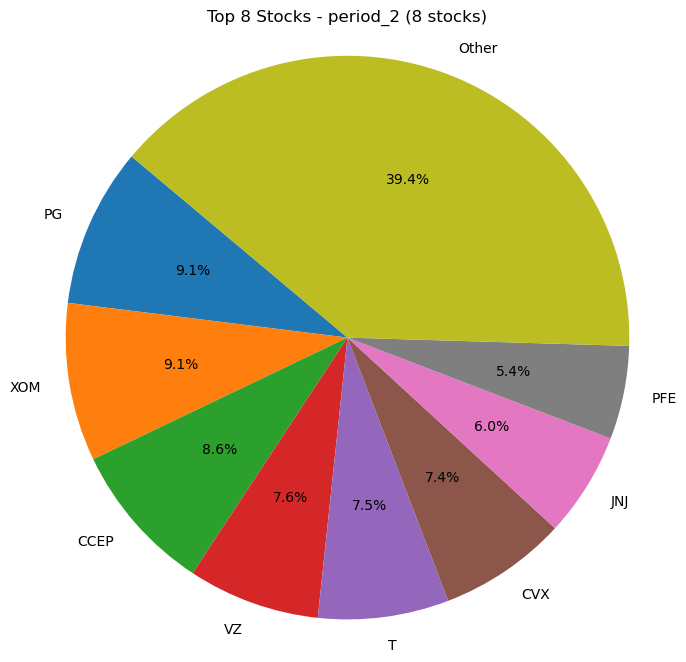

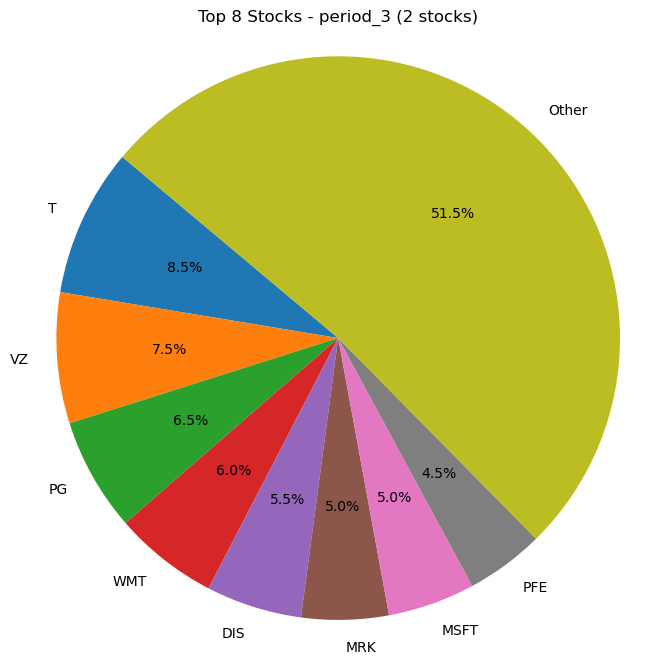

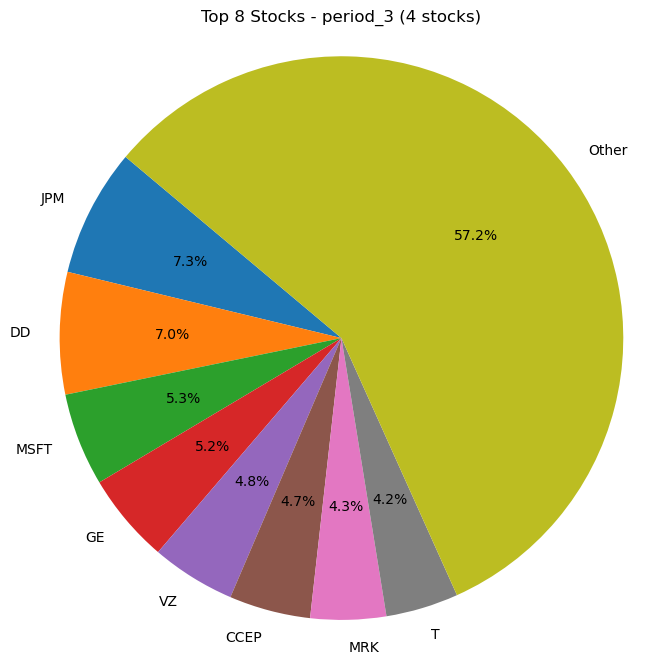

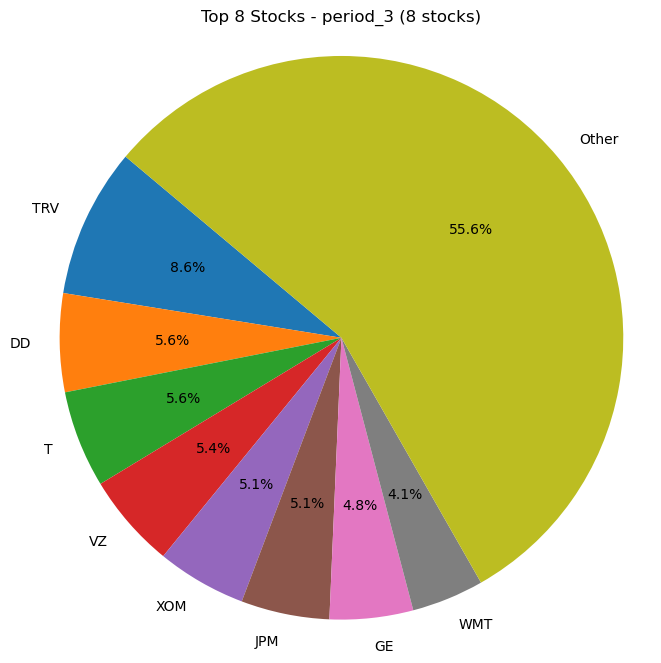

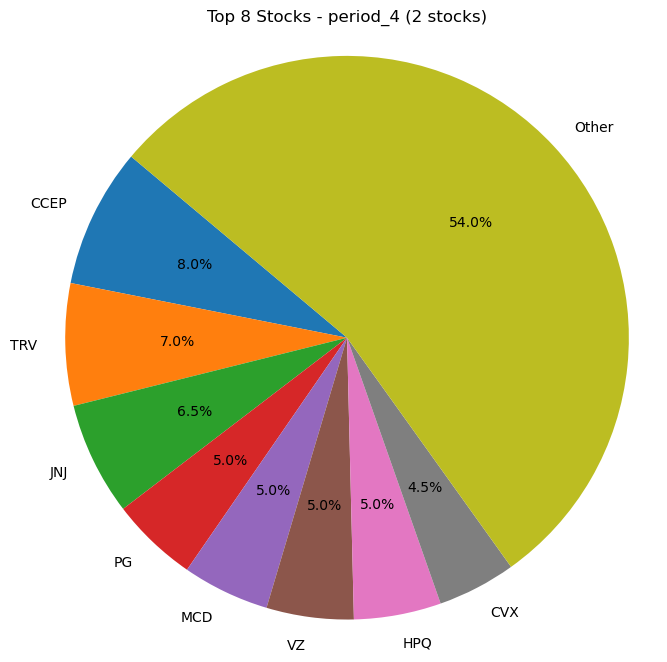

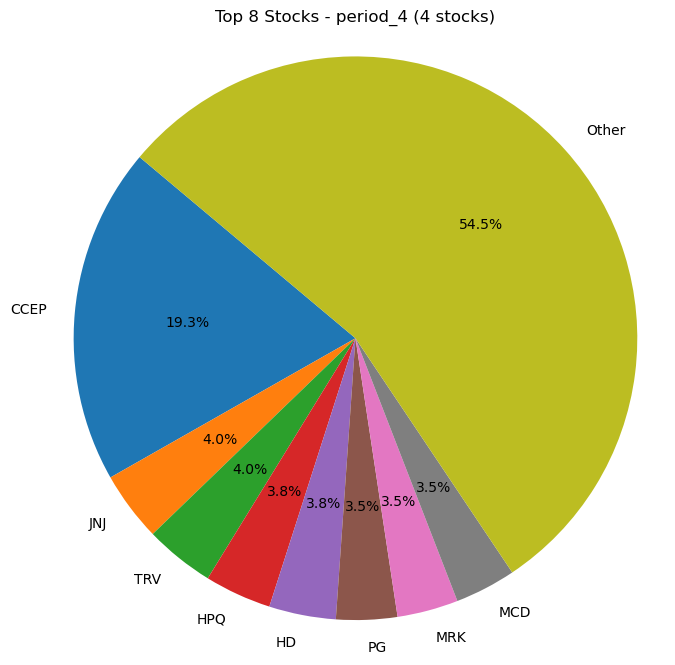

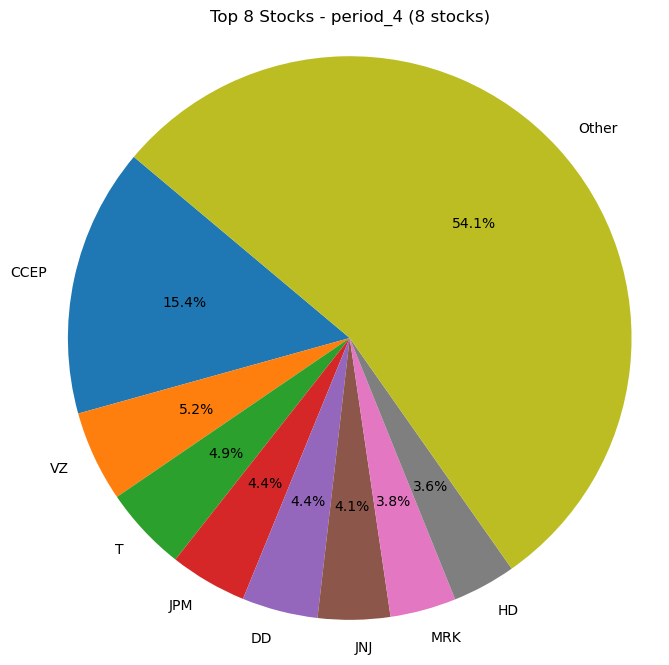

In [11]:
for period, group in result_df_clusters.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers, columns=[period])

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers
    total_counts = counts_df.sum(axis=1)

    # Get the top 8 stocks and group the rest into "Other"
    top_8 = total_counts.nlargest(8)
    other = pd.Series(total_counts.sum() - top_8.sum(), index=["Other"])

    # Concatenate the top 8 and "Other"
    final_counts = pd.concat([top_8, other])

    # Plot the pie chart for the current period
    plt.figure(figsize=(8, 8))
    plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Top 8 Stocks - {period}')
    plt.show()

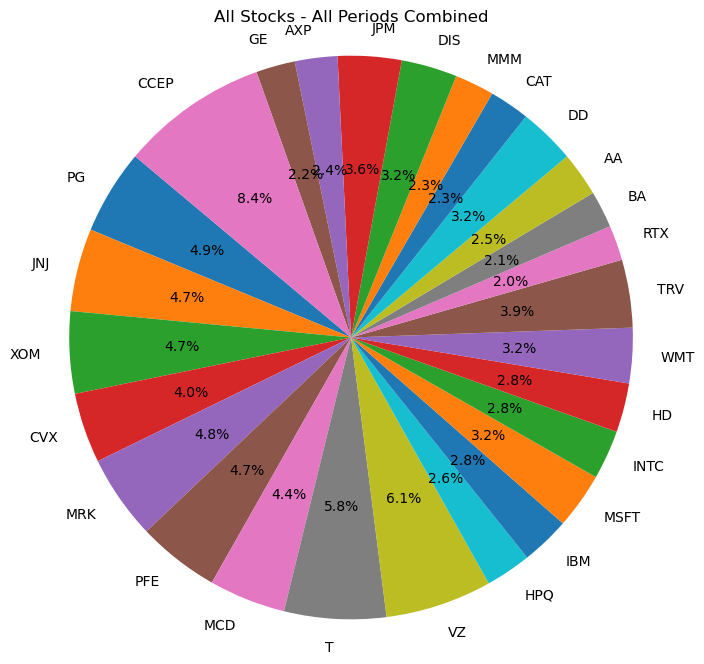

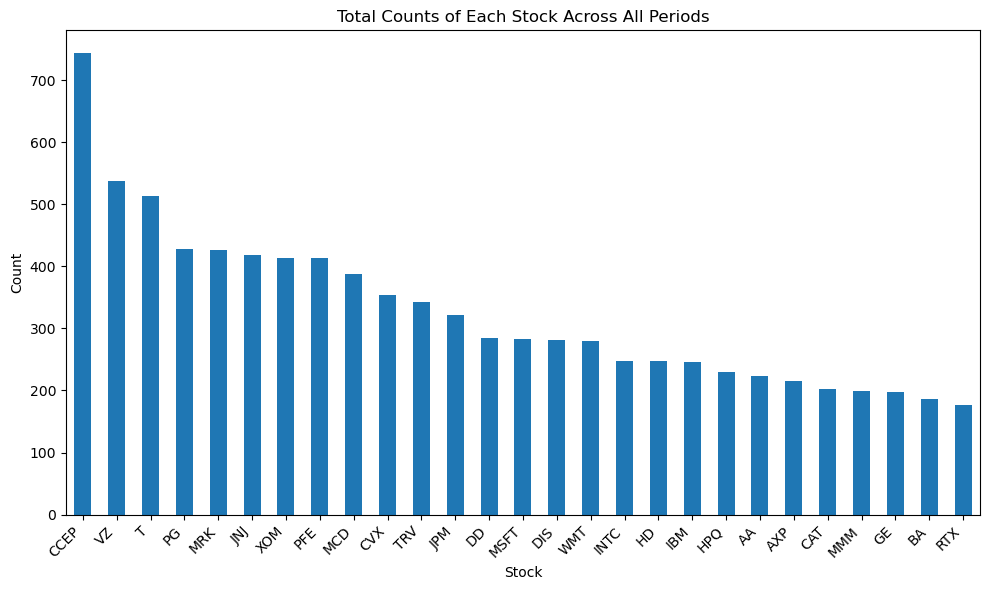

In [12]:
total_counts_df = pd.DataFrame(index=custom_tickers)

# Iterate over each period
for period, group in result_df_clusters.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers)

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers for the current period
    total_counts_df[period] = counts_df.sum(axis=1)

# Sum the counts across all periods
total_counts = total_counts_df.sum(axis=1)

# Plot the pie chart for all periods combined
plt.figure(figsize=(8, 8))
plt.pie(total_counts, labels=total_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('All Stocks - All Periods Combined')
plt.show()

total_counts_df = pd.DataFrame(index=custom_tickers)

# Iterate over each period
for period, group in result_df_clusters.groupby(level=0):
    # Create an empty DataFrame to store counts for the current period
    counts_df = pd.DataFrame(index=custom_tickers)

    # Count occurrences of each ticker in the current period
    ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
    counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

    # Sum the counts across tickers for the current period
    total_counts_df[period] = counts_df.sum(axis=1)

# Sum the counts across all periods
total_counts = total_counts_df.sum(axis=1)

# Sort the total counts in descending order
total_counts_sorted = total_counts.sort_values(ascending=False)

# Plot the bar chart for all periods combined
plt.figure(figsize=(10, 6))
total_counts_sorted.plot(kind='bar')
plt.xlabel('Stock')
plt.ylabel('Count')
plt.title('Total Counts of Each Stock Across All Periods')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

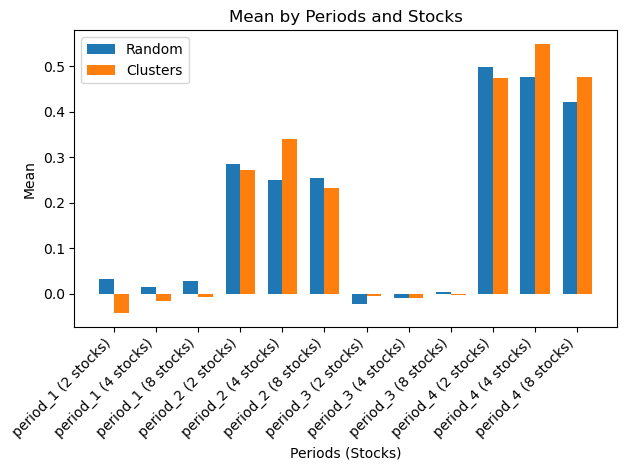

Total Average Mean of Random Values: 0.18582978466206856
Total Average Mean of Cluster Values: 0.18844581496008161

Period 1 Average Mean of Random Values: 0.024515559963604692
Period 1 Average Mean of Cluster Values: -0.021964096672528962
Period 2 Average Mean of Random Values: 0.2635413364431866
Period 2 Average Mean of Cluster Values: 0.2819092730733194
Period 3 Average Mean of Random Values: -0.009770729904043948
Period 3 Average Mean of Cluster Values: -0.006619620985372078


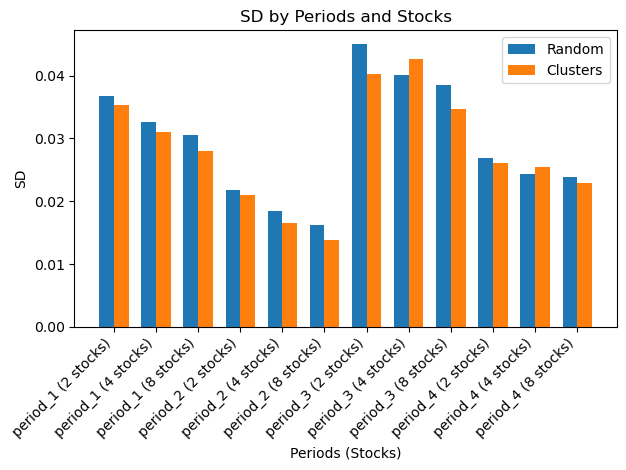

Total Average SD of Random Values: 0.02957383915381581
Total Average SD of Cluster Values: 0.028143754421382897

Period 1 Average SD of Random Values: 0.033357817967803925
Period 1 Average SD of Cluster Values: 0.03146029994324803
Period 2 Average SD of Random Values: 0.01876345184050782
Period 2 Average SD of Cluster Values: 0.017123158404793132
Period 3 Average SD of Random Values: 0.04119743270254941
Period 3 Average SD of Cluster Values: 0.039157714660824634


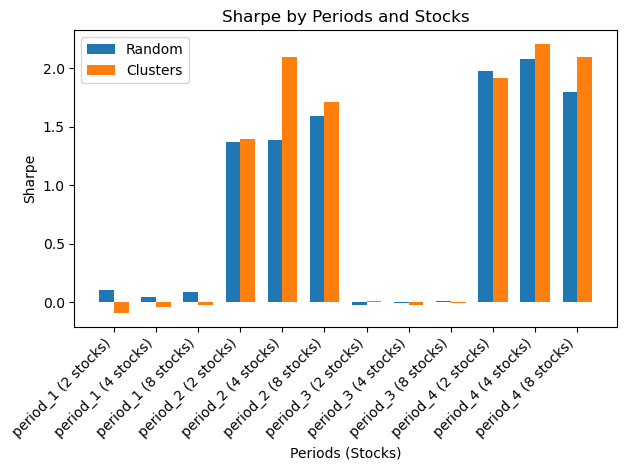

Total Average Sharpe of Random Values: 0.8684328040692787
Total Average Sharpe of Cluster Values: 0.9366503721747023

Period 1 Average Sharpe of Random Values: 0.08009852913699693
Period 1 Average Sharpe of Cluster Values: -0.052476719728821675
Period 2 Average Sharpe of Random Values: 1.450066142427923
Period 2 Average Sharpe of Cluster Values: 1.7339990728546528
Period 3 Average Sharpe of Random Values: -0.0035379081606330236
Period 3 Average Sharpe of Cluster Values: -0.007118115868407261


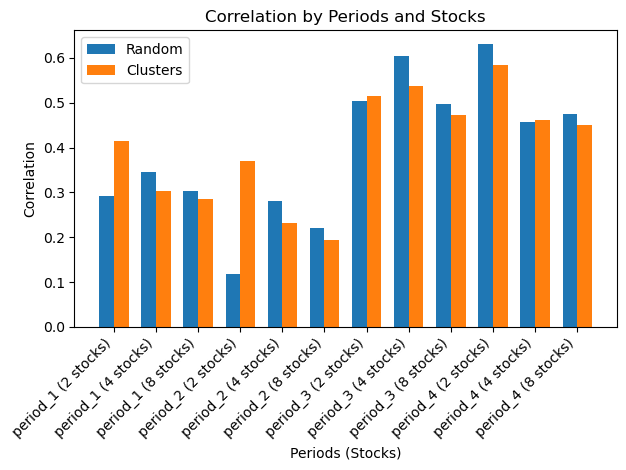

Total Average Correlation of Random Values: 0.39387573807129234
Total Average Correlation of Cluster Values: 0.40169830928956296

Period 1 Average Correlation of Random Values: 0.3133543414359304
Period 1 Average Correlation of Cluster Values: 0.33447279716425055
Period 2 Average Correlation of Random Values: 0.20682881940770778
Period 2 Average Correlation of Cluster Values: 0.26508253171205715
Period 3 Average Correlation of Random Values: 0.5351931676937015
Period 3 Average Correlation of Cluster Values: 0.5085443349825546


In [13]:
def plot_metric(metric_name):
    labels = list(result_df_random.index)
    
    random_values = [result_df_random.loc[label][metric_name] for label in labels]
    cluster_values = [result_df_clusters.loc[label][metric_name] for label in labels]

    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, random_values, width, label='Random')
    rects2 = ax.bar([i + width for i in x], cluster_values, width, label='Clusters')

    ax.set_xlabel('Periods (Stocks)')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Periods and Stocks')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    plt.show()

    #print(random_values)
    #print(cluster_values)
    
    print("Total Average " + metric_name + " of Random Values:", np.mean(random_values))
    print("Total Average " + metric_name + " of Cluster Values:", np.mean(cluster_values))
    print()
    periods = ["Period 1", "Period 2", "Period 3"]  # Update with your periods
    for period_num, period_label in enumerate(periods, start=1):
        print(period_label + " Average " + metric_name + " of Random Values:", np.mean(random_values[(period_num - 1) * 3:period_num * 3]))
        print(period_label + " Average " + metric_name + " of Cluster Values:", np.mean(cluster_values[(period_num - 1) * 3:period_num * 3]))

# Plotting Mean
plot_metric('Mean')

# Plotting SD
plot_metric('SD')

# Plotting Sharpe
plot_metric('Sharpe')

# Plotting Correlation
plot_metric('Correlation')

In [14]:
###### START OF CART ######

In [15]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [16]:
def CART(weekly_returns_dict, study_periods):
    all_cluster_stocks = {}  # Initialize as a dictionary

    for period_num, (start_date, end_date) in enumerate(study_periods, start=1):
        # Initialize features and labels lists
        features = []
        labels = []
        
        # Iterate over each ticker's data
        for ticker, data in weekly_returns_dict.items():
            # Select data for the current period
            period_data = data[f'period_{period_num}']
            # Assuming features are weekly returns
            features.append(period_data['returns'].values)
            labels.append(ticker)

        # Convert lists to numpy arrays
        features = np.array(features)
        labels = np.array(labels)

        # Use LabelEncoder to generate integer labels for clusters
        label_encoder = LabelEncoder()
        cluster_labels = label_encoder.fit_transform(labels)

        # Train a Decision Tree Classifier
        clf = DecisionTreeClassifier()
        clf.fit(features, cluster_labels)

        # Predict cluster labels
        cluster_labels = clf.predict(features)

        # Calculate the number of clusters to create
        num_clusters = len(np.unique(cluster_labels))

        # Generate clusters of 2, 4, and 8
        clusters = {}
        for size in [2, 4, 8]:
            # Initialize cluster lists
            clusters[size] = {}
            for cluster_num in range(1, size + 1):
                clusters[size][cluster_num] = []

        # Assign stocks to clusters based on the predicted labels
        for label, ticker in zip(cluster_labels, labels):
            for size in [2, 4, 8]:
                cluster_num = label % size + 1
                clusters[size][cluster_num].append(ticker)

        # Label the period in the clusters dictionary
        period_label = f'period_{period_num}'
        all_cluster_stocks[period_label] = clusters  # Use period label as key

    return all_cluster_stocks

In [17]:
all_CART_cluster_stocks = CART(weekly_returns_dict, study_periods)

In [18]:
#get a result similar to all_cluster_stock to check stock distribution and metrics
results_by_period_CART = calculate_metrics_for_all_clusters(all_CART_cluster_stocks, period_dfs)

dfs_CART = []
for period, results_by_cluster in results_by_period_CART.items():
    for num_clusters, metrics in results_by_cluster.items():
        df = pd.DataFrame(metrics, index=[f"{period} ({num_clusters} stocks)"])
        dfs_CART.append(df)

result_df_clusters_CART = pd.concat(dfs_CART)
result_df_clusters_CART

Mean        SD    Sharpe  Correlation  \
period_1 (2 stocks)  0.007351  0.038693  0.036788     0.288607   
period_1 (4 stocks)  0.019238  0.033559  0.059881     0.354897   
period_1 (8 stocks)  0.041865  0.030504  0.136514     0.382344   
period_2 (2 stocks)  0.286428  0.021436  1.365788     0.308495   
period_2 (4 stocks)  0.259345  0.018283  1.457887     0.382471   
period_2 (8 stocks)  0.237925  0.016016  1.517220     0.228977   
period_3 (2 stocks) -0.006819  0.041819  0.012329     0.551268   
period_3 (4 stocks)  0.002168  0.040031  0.019556     0.459300   
period_3 (8 stocks)  0.027821  0.037164  0.074837     0.518913   
period_4 (2 stocks)  0.418145  0.027150  1.679772     0.420038   
period_4 (4 stocks)  0.411930  0.025152  1.712632     0.560702   
period_4 (8 stocks)  0.426388  0.023304  1.867618     0.506717   

                                                                Stocks  
period_1 (2 stocks)  [DD, CAT, HPQ, RTX, DD, IBM, AA, MRK, XOM, CAT...  
period_1 (4 stocks)  [DD, CAT, HPQ, RTX, DD, IBM, AA, MRK, XOM, CAT...  
period_1 (8 stocks)  [DD, CAT, HPQ, RTX, DD, IBM, AA, MRK, XOM, CAT...  
period_2 (2 stocks)  [DD, DIS, MSFT, HD, JPM, TRV, BA, DIS, VZ, PFE...  
period_2 (4 stocks)  [DD, DIS, MSFT, HD, JPM, TRV, BA, DIS, VZ, PFE...  
period_2 (8 stocks)  [DD, DIS, MSFT, HD, JPM, TRV, BA, DIS, VZ, PFE...  
period_3 (2 stocks)  [GE, CAT, BA, DIS, AA, CVX, CCEP, MRK, T, CVX,...  
period_3 (4 stocks)  [GE, CAT, BA, DIS, AA, CVX, CCEP, MRK, T, CVX,...  
period_3 (8 stocks)  [GE, CAT, BA, DIS, AA, CVX, CCEP, MRK, T, CVX,...  
period_4 (2 stocks)  [XOM, PFE, T, PFE, JPM, JNJ, XOM, MRK, DD, AXP...  
period_4 (4 stocks)  [XOM, PFE, T, PFE, JPM, JNJ, XOM, MRK, DD, AXP...  
period_4 (8 stocks)  [XOM, PFE, T, PFE, JPM, JNJ, XOM, MRK, DD, AXP...

In [19]:
#convert previous code from clustering to use for any result all_cluster_stock
def count_of_stocks(result_df_clusters):
    for period, group in result_df_clusters.groupby(level=0):
        # Create an empty DataFrame to store counts for the current period
        counts_df = pd.DataFrame(index=custom_tickers, columns=[period])

        # Count occurrences of each ticker in the current period
        ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
        counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

        # Sum the counts across tickers
        total_counts = counts_df.sum(axis=1)

        # Get the top 8 stocks and group the rest into "Other"
        top_8 = total_counts.nlargest(8)
        other = pd.Series(total_counts.sum() - top_8.sum(), index=["Other"])

        # Concatenate the top 8 and "Other"
        final_counts = pd.concat([top_8, other])

        # Plot the pie chart for the current period
        plt.figure(figsize=(8, 8))
        plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        plt.title(f'Top 8 Stocks - {period}')
        plt.show()
        total_counts_df = pd.DataFrame(index=custom_tickers)

    # Iterate over each period
    for period, group in result_df_clusters.groupby(level=0):
        # Create an empty DataFrame to store counts for the current period
        counts_df = pd.DataFrame(index=custom_tickers)

        # Count occurrences of each ticker in the current period
        ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
        counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

        # Sum the counts across tickers for the current period
        total_counts_df[period] = counts_df.sum(axis=1)

    # Sum the counts across all periods
    total_counts = total_counts_df.sum(axis=1)

    # Plot the pie chart for all periods combined
    plt.figure(figsize=(8, 8))
    plt.pie(total_counts, labels=total_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('All Stocks - All Periods Combined')
    plt.show()

    ################################################################################################
    total_counts_df = pd.DataFrame(index=custom_tickers)

    # Iterate over each period
    for period, group in result_df_clusters.groupby(level=0):
        # Create an empty DataFrame to store counts for the current period
        counts_df = pd.DataFrame(index=custom_tickers)

        # Count occurrences of each ticker in the current period
        ticker_counts = pd.Series(group["Stocks"].sum()).value_counts()
        counts_df[period] = ticker_counts.reindex(custom_tickers, fill_value=0)

        # Sum the counts across tickers for the current period
        total_counts_df[period] = counts_df.sum(axis=1)

    # Sum the counts across all periods
    total_counts = total_counts_df.sum(axis=1)

    # Sort the total counts in descending order
    total_counts_sorted = total_counts.sort_values(ascending=False)

    # Plot the bar chart for all periods combined
    plt.figure(figsize=(10, 6))
    total_counts_sorted.plot(kind='bar')
    plt.xlabel('Stock')
    plt.ylabel('Count')
    plt.title('Total Counts of Each Stock Across All Periods')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

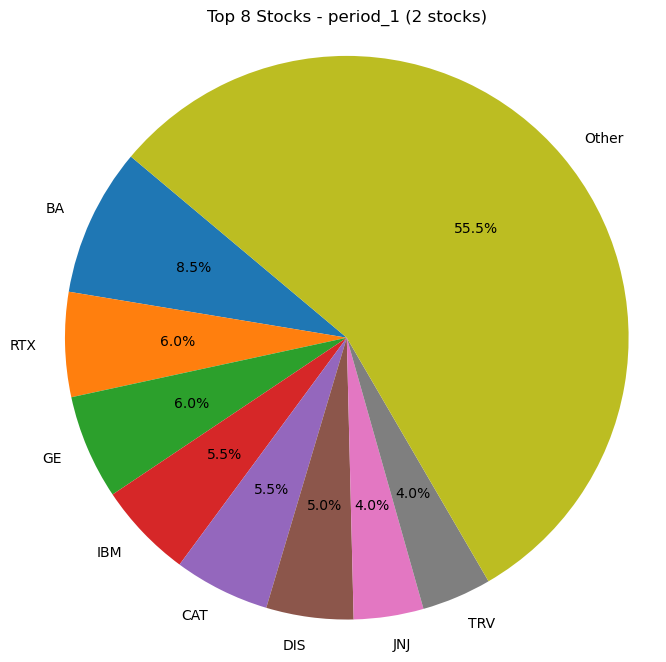

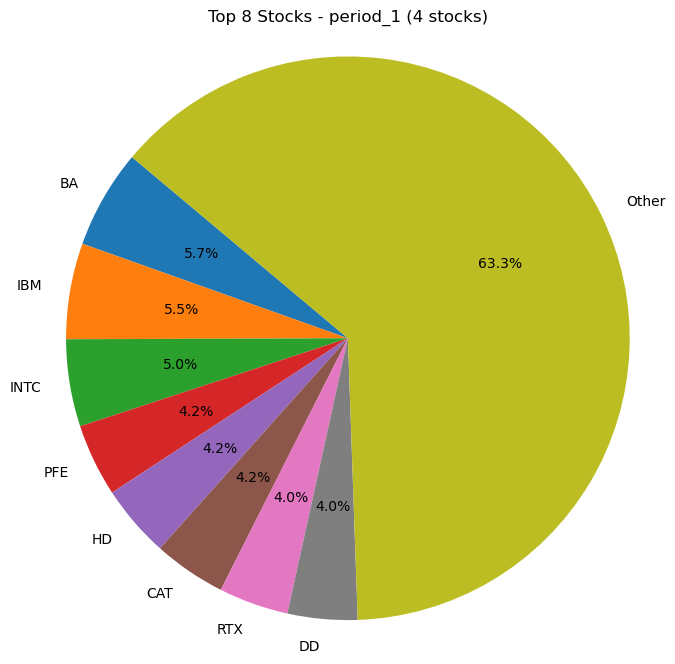

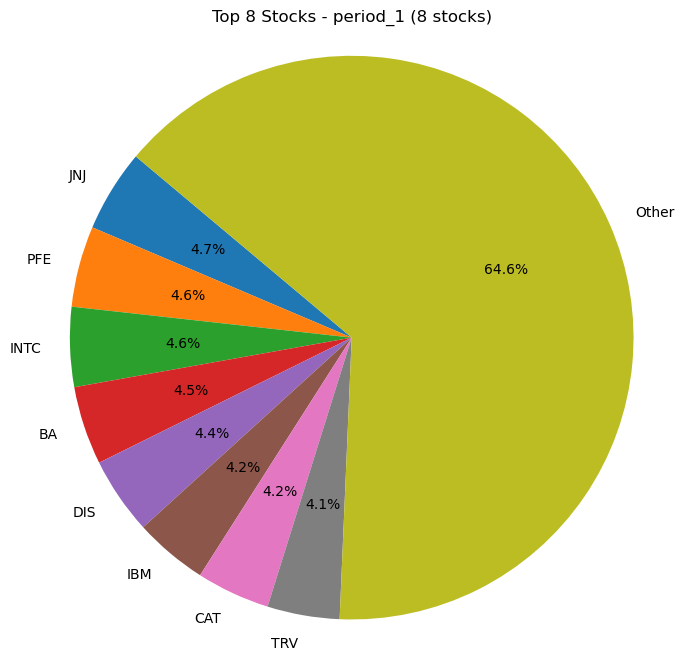

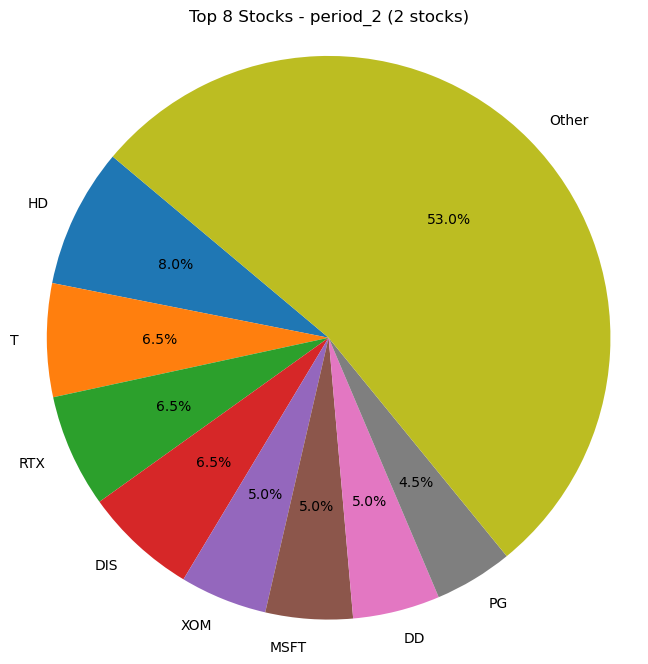

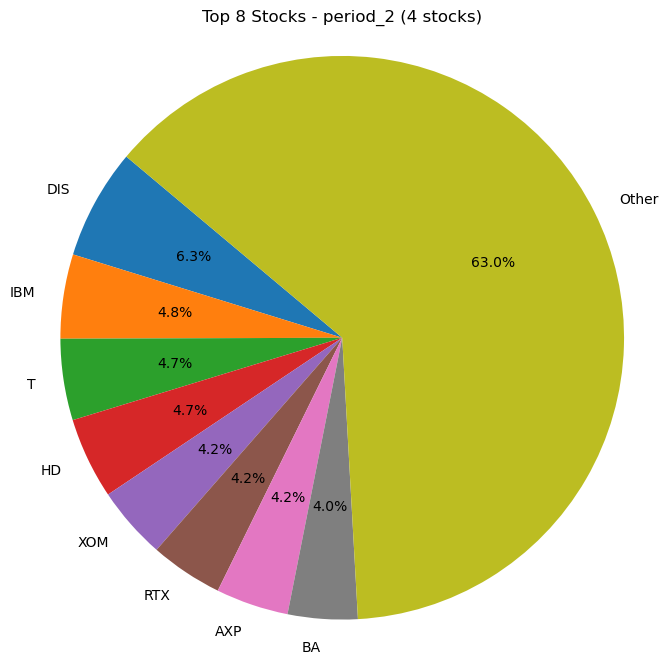

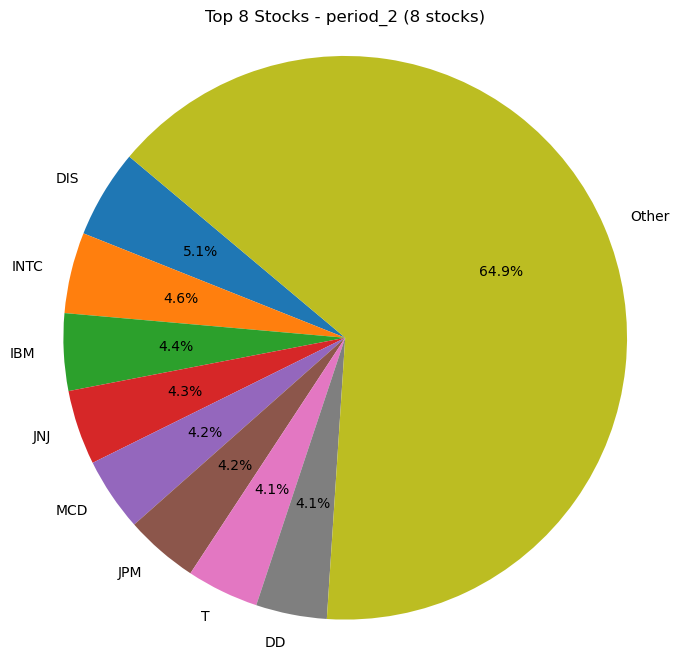

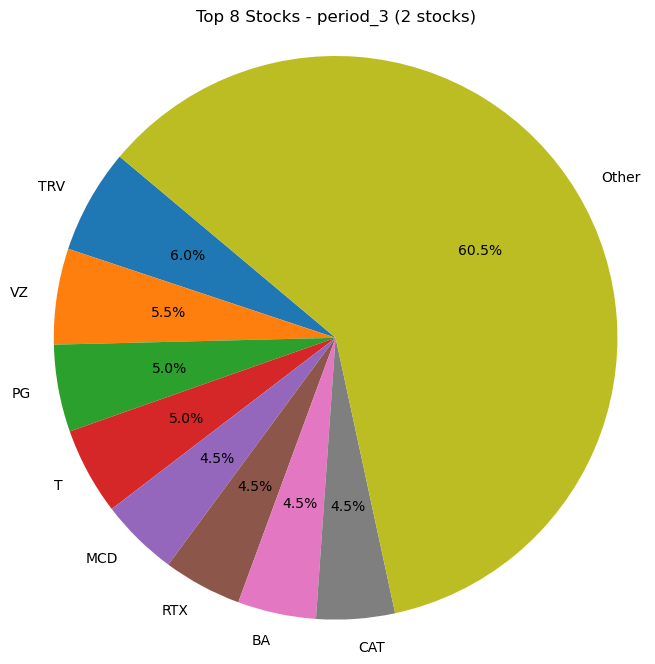

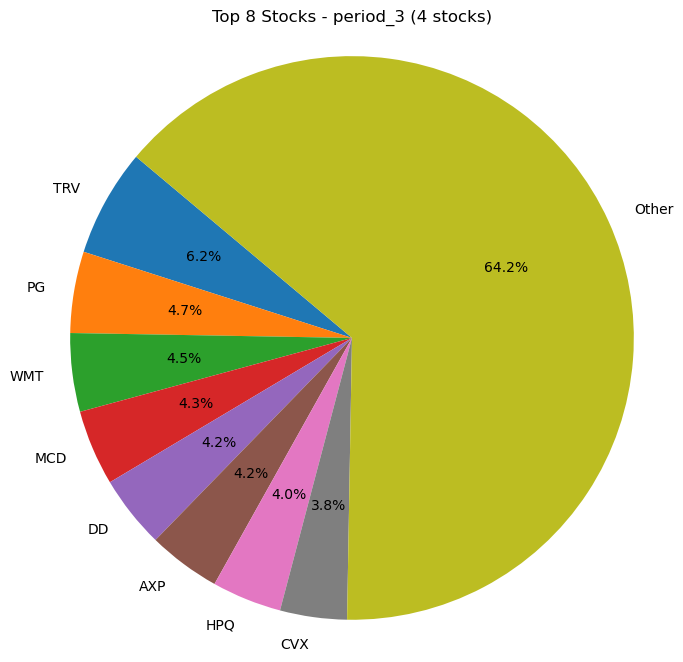

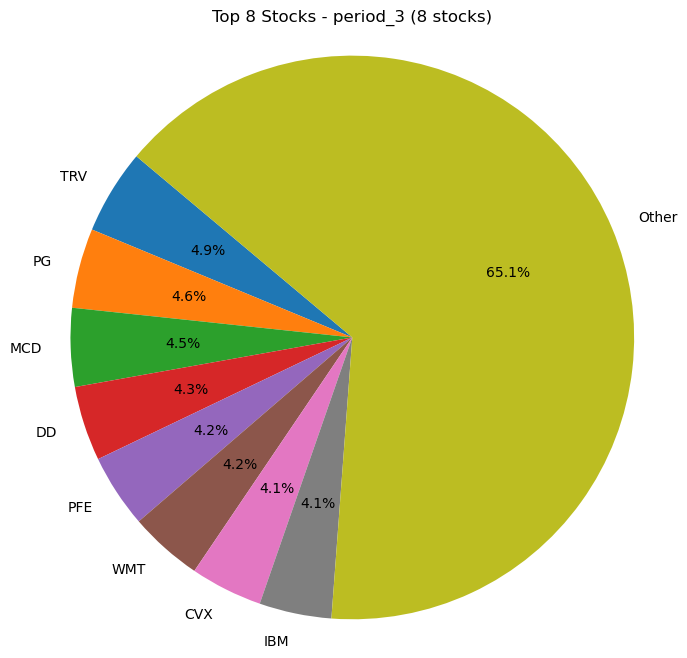

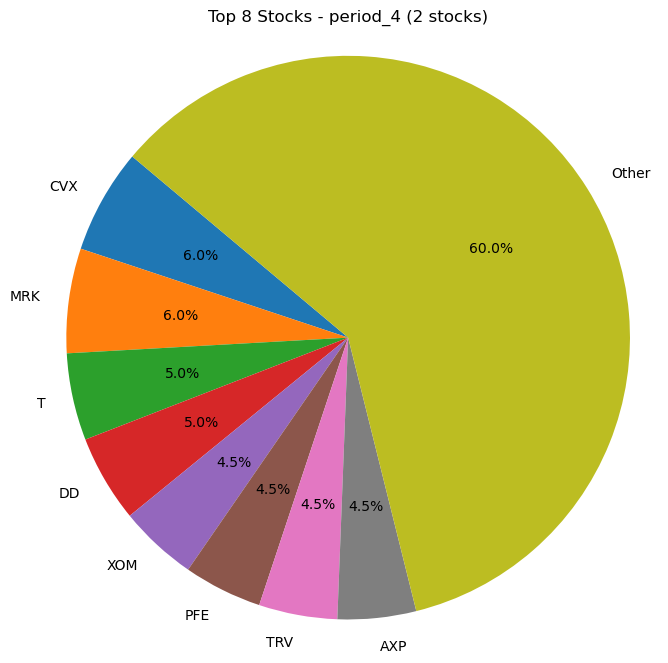

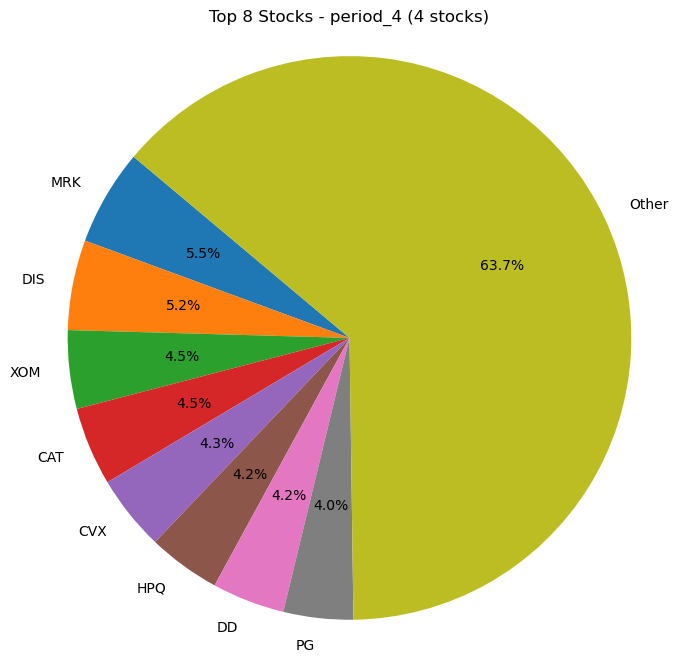

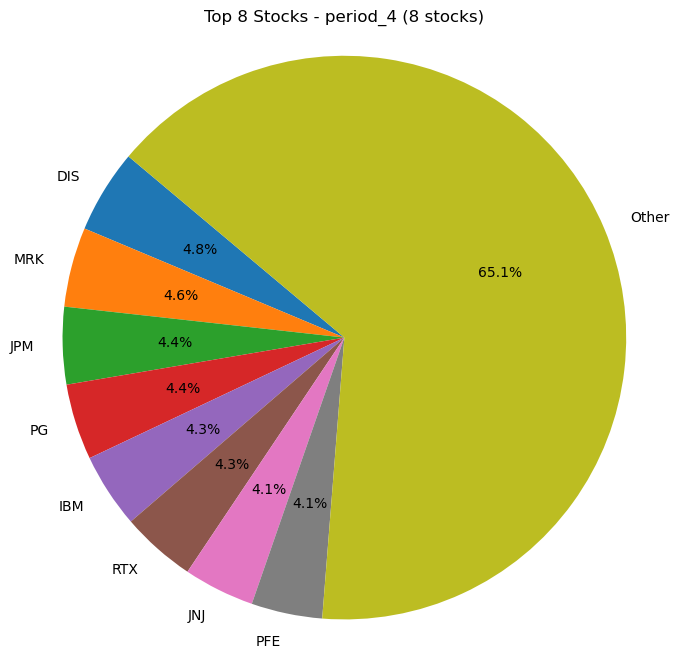

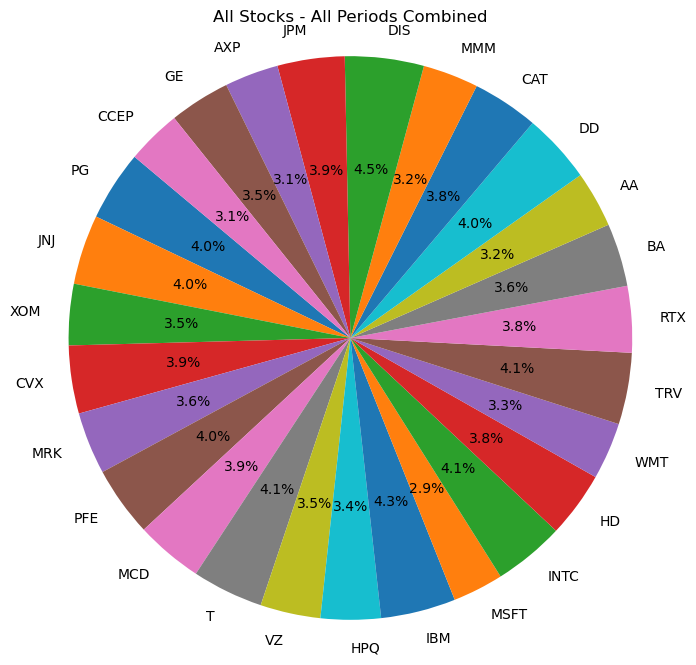

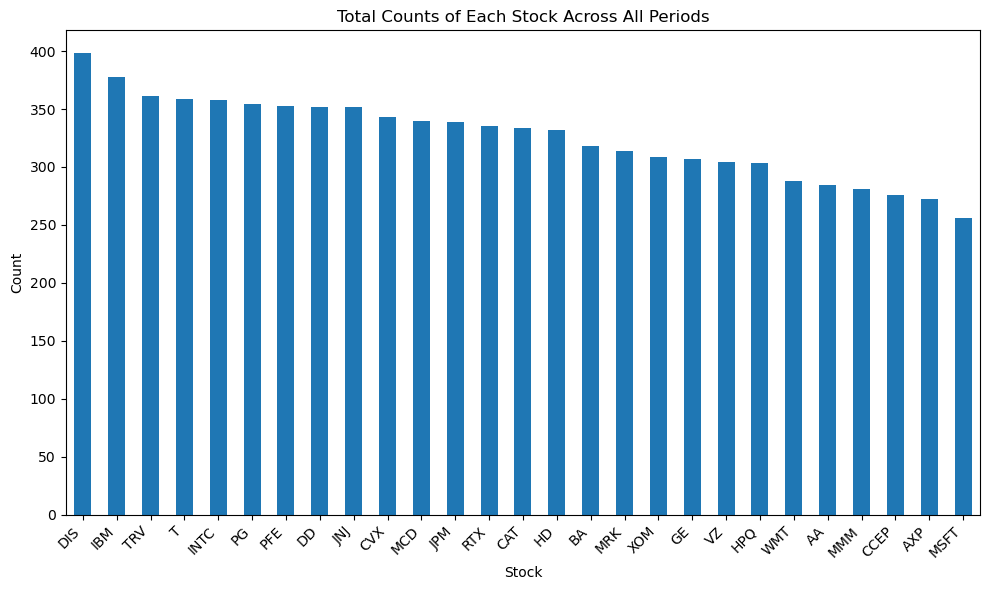

In [20]:
count_of_stocks(result_df_clusters_CART)

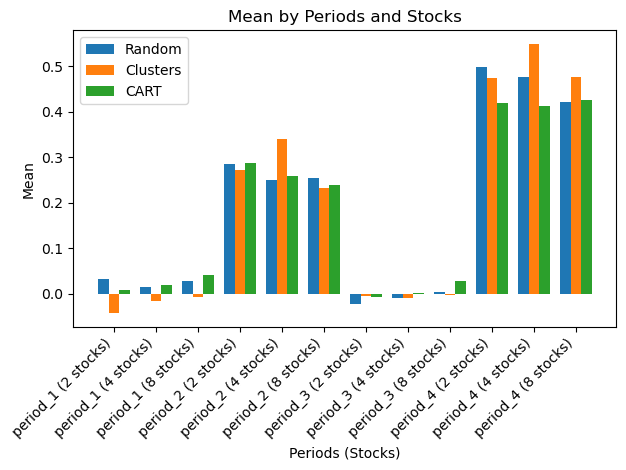

Total Average Mean of Random Values: 0.18582978466206856
Total Average Mean of Cluster Values: 0.18844581496008161
Total Average Mean of CART Values: 0.1776486790794

Period 1 Average Mean of Random Values: 0.024515559963604692
Period 1 Average Mean of Cluster Values: -0.021964096672528962
Period 1 Average Mean of CART Values: 0.022817975117366218
Period 2 Average Mean of Random Values: 0.2635413364431866
Period 2 Average Mean of Cluster Values: 0.2819092730733194
Period 2 Average Mean of CART Values: 0.26123243293245585
Period 3 Average Mean of Random Values: -0.009770729904043948
Period 3 Average Mean of Cluster Values: -0.006619620985372078
Period 3 Average Mean of CART Values: 0.00772321974068332


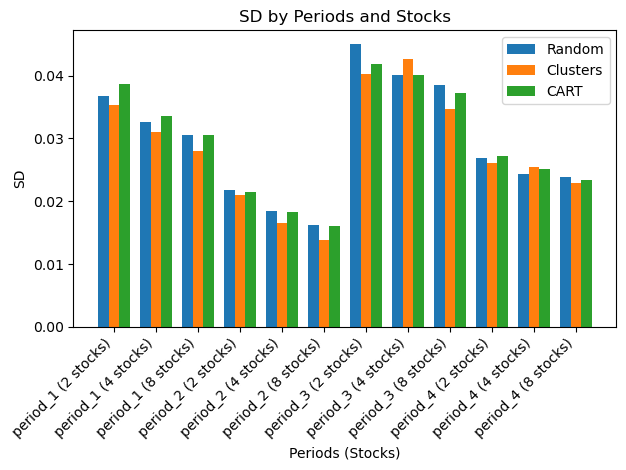

Total Average SD of Random Values: 0.02957383915381581
Total Average SD of Cluster Values: 0.028143754421382897
Total Average SD of CART Values: 0.029425871376127594

Period 1 Average SD of Random Values: 0.033357817967803925
Period 1 Average SD of Cluster Values: 0.03146029994324803
Period 1 Average SD of CART Values: 0.034252150488431894
Period 2 Average SD of Random Values: 0.01876345184050782
Period 2 Average SD of Cluster Values: 0.017123158404793132
Period 2 Average SD of CART Values: 0.018577957936813726
Period 3 Average SD of Random Values: 0.04119743270254941
Period 3 Average SD of Cluster Values: 0.039157714660824634
Period 3 Average SD of CART Values: 0.039671342220053085


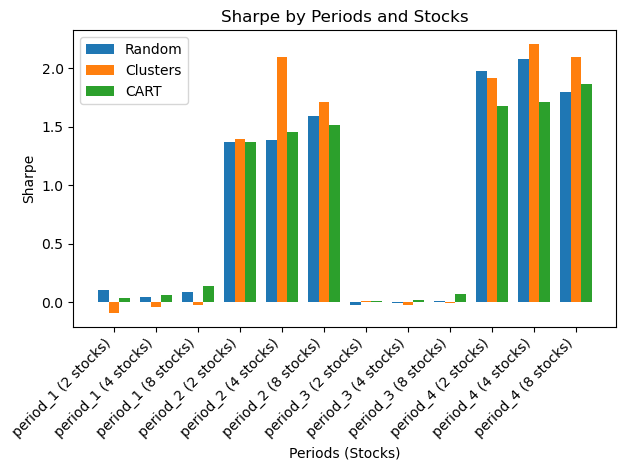

Total Average Sharpe of Random Values: 0.8684328040692787
Total Average Sharpe of Cluster Values: 0.9366503721747023
Total Average Sharpe of CART Values: 0.8284018342415044

Period 1 Average Sharpe of Random Values: 0.08009852913699693
Period 1 Average Sharpe of Cluster Values: -0.052476719728821675
Period 1 Average Sharpe of CART Values: 0.07772749817434657
Period 2 Average Sharpe of Random Values: 1.450066142427923
Period 2 Average Sharpe of Cluster Values: 1.7339990728546528
Period 2 Average Sharpe of CART Values: 1.446965338694332
Period 3 Average Sharpe of Random Values: -0.0035379081606330236
Period 3 Average Sharpe of Cluster Values: -0.007118115868407261
Period 3 Average Sharpe of CART Values: 0.03557394941340981


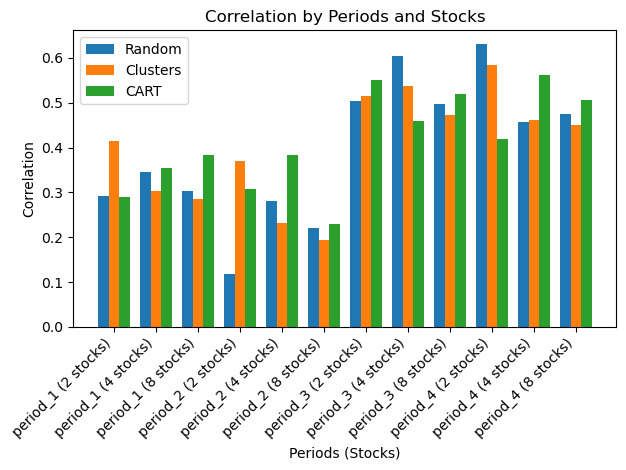

Total Average Correlation of Random Values: 0.39387573807129234
Total Average Correlation of Cluster Values: 0.40169830928956296
Total Average Correlation of CART Values: 0.41356065411797927

Period 1 Average Correlation of Random Values: 0.3133543414359304
Period 1 Average Correlation of Cluster Values: 0.33447279716425055
Period 1 Average Correlation of CART Values: 0.34194918848528205
Period 2 Average Correlation of Random Values: 0.20682881940770778
Period 2 Average Correlation of Cluster Values: 0.26508253171205715
Period 2 Average Correlation of CART Values: 0.306647748540619
Period 3 Average Correlation of Random Values: 0.5351931676937015
Period 3 Average Correlation of Cluster Values: 0.5085443349825546
Period 3 Average Correlation of CART Values: 0.5098266384261261


In [21]:
def plot_metric(metric_name):
    labels = list(result_df_random.index)
    
    random_values = [result_df_random.loc[label][metric_name] for label in labels]
    cluster_values = [result_df_clusters.loc[label][metric_name] for label in labels]
    CART_values = [result_df_clusters_CART.loc[label][metric_name] for label in labels]

    x = np.arange(len(labels))  # Use numpy's arange for better precision
    width = 0.25  # Adjust width for better spacing between bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, random_values, width, label='Random')
    rects2 = ax.bar(x, cluster_values, width, label='Clusters')
    rects3 = ax.bar(x + width, CART_values, width, label='CART')  # Adjust x-coordinate for CART values

    ax.set_xlabel('Periods (Stocks)')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Periods and Stocks')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    plt.show()

    print("Total Average " + metric_name + " of Random Values:", np.mean(random_values))
    print("Total Average " + metric_name + " of Cluster Values:", np.mean(cluster_values))
    print("Total Average " + metric_name + " of CART Values:", np.mean(CART_values))
    print()
    periods = ["Period 1", "Period 2", "Period 3"]  # Update with your periods
    for period_num, period_label in enumerate(periods, start=1):
        print(period_label + " Average " + metric_name + " of Random Values:", np.mean(random_values[(period_num - 1) * 3:period_num * 3]))
        print(period_label + " Average " + metric_name + " of Cluster Values:", np.mean(cluster_values[(period_num - 1) * 3:period_num * 3]))
        print(period_label + " Average " + metric_name + " of CART Values:", np.mean(CART_values[(period_num - 1) * 3:period_num * 3]))

# Plotting Mean
plot_metric('Mean')

# Plotting SD
plot_metric('SD')

# Plotting Sharpe
plot_metric('Sharpe')

# Plotting Correlation
plot_metric('Correlation')